# This notebook helps to process all participants' rest and concentration EEG data. This MUST occur before any actual experiment trial is conducted.

---
This notebook attempts to perform Wilcoxon Signed Rank Correlation tests on rest and concentration states. Here are some assumptions made by this notebook:

1. All EEG data is collected with the [*Mind Monitor*](https://mind-monitor.com/) mobile application using a [*Muse 2*](https://choosemuse.com/products/muse-2) or [*Muse S*](https://choosemuse.com/products/muse-s-gen-2) headband.
2. All user data is contained in a relative `./data/` directory. Within it contains the following files:
    - `participants.csv`: From users' demographic survey data.
    - `rest_conc/`: sub-directory containing all participants' rest and concentration data. Each participant should have 4 files, to match the four separate trials conducted (**RestNoHMD**, **RestHMD**, **Conc2D**, and **Conc3D**). All files should have a specific naming structure: `<id>-<'rest'/'conc'>-<'novr'/'vr'/'2d'/'3d'>`. For example: `p3-rest-novr.csv`.
    
## Objectives:

1. _Extract_ the median, min, and max data of each freq-electrode columns, for each participant
2. _Conduct_ a **Wilcoxon Signed Rank Test** ([Src](https://www.statisticssolutions.com/free-resources/directory-of-statistical-analyses/how-to-conduct-the-wilcox-sign-test/), [Python Code](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html)) on median differences between rest and concentration states.
3. _Answer_ the following questions:
    * Is there a significant difference between the resting state of the HMD vs non-HMD?
    * Is there a significant difference between the 2D and 3D red ball experiment?

The file prints out.a single CSV file containing the necessary resting state for use in trial analysis

## Motivation 

The idea of this entire analysis is to identify if the concentration condition produces a difference. AKA if the introduction of a red-ball concentration test induces people to create differences in concentration level. Of course, this assumes that we have some paired data (i.e. for each participant, we have a "before" and "after" condition). This, of course, is true - we have the rest state come before the concentration state in all participants. However, this kind of test assumes that our hypothesis is that "the red ball test resulted in a statistically significant difference in concentration levels among participants". The intention is subtle - in our original question, we posit whether there even is a difference, while the statistical significant test posits whether the introduction of a new condition __creates__ a difference. Subtle, to be sure, but something we must acknowledge. This means there's a dependence between the two conditions - a before and after, in most cases.

There might be some ways to go about this. One can try to identify which data corresponds with their order, then flip them accordingly. Another might be to just find the absolute differences so that we only care about the magnitude of the differences. This might be the direction we want to go down in the end - after all, our null hypothesis is that the introduction of the red ball concentration task does not induce a difference in eeg log power level. Since the log power effect is applied to all data columns and rows, seeing changes in that will also echo changes in the true absolute power of the eeg data.

For now, we go with Wilcoxon Signed Rank Test, which allows us to measure this difference without any assumption of normality in data points. We just have to account for the absolute difference in the condition instead.

# 0. Import Packages, Global Variables

In [1]:
### ==== Core Python Packages ===== ###
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import os
import matplotlib.pyplot as plt
import datetime
import shutil
import math
import importlib

### ===== Situational Python Packages ===== ###
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
from scipy.stats import wilcoxon

### ===== Helper functions located in `./helpers.py` ===== ###
# Participant Data Handling
from helpers import filter_out_participants
from helpers import merge_participants
from helpers import merge_and_filter_participants
from helpers import participant_stats

# Time converters
from helpers import timestamp_to_unix_seconds as unix_seconds # Timestamps to Unix Seconds
from helpers import timestamp_to_unix_milliseconds as unix_milliseconds # Timestamps to Unix Milliseconds

# File Handling
from helpers import get_immediate_subdirectories
from helpers import get_immediate_files

# EEG Pre-processing
from helpers import process_raw_eeg

# Renaming Dictionary
_PARTICIPANTS_RENAME_DICT = {
    'ID':'participant', 
    'D1':'sex', 
    'VR1':'vr_experience',
    'VR2':'vr_frequency',
    'VR3':'vr_sickness',
    'OV1':'corrective_vision', 
    'OV2':'vision_diagnosis', 
    'OV3':'vision_condition', 
    'N1':'neural_diagnosis', 
    'N2':'neural_condition'
}

# EEG-Electrode combos (AKA column names)
_POWER_COLS = [
    'Delta_AF7', 'Delta_AF8', 'Delta_TP9', 'Delta_TP10',
    'Theta_AF7', 'Theta_AF8', 'Theta_TP9', 'Theta_TP10',
    'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP9', 'Alpha_TP10',
    'Beta_AF7',  'Beta_AF8',  'Beta_TP9',  'Beta_TP10',
    'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP9', 'Gamma_TP10'
]

# Aggregation: Median, Min, and Max
_MEDIAN_AGGR_DICT = {key:'median' for key in _POWER_COLS}
_MIN_AGGR_DICT = {key:'min' for key in _POWER_COLS}
_MIN_RENAME_DICT = {key:f'{key}_min' for key in _POWER_COLS}
_MAX_AGGR_DICT = {key:'max' for key in _POWER_COLS}
_MAX_RENAME_DICT = {key:f'{key}_max' for key in _POWER_COLS}

In [2]:
"""  ___________________________________  """
""" |TO-DOs:                            | """
""" | - Set the relative path data      | """
""" | - Change frequencies of ineterest | """
"""   ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅  """
_DATA_DIR = './data/'
_FREQUENCY_BANDS = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']
_ELECTRODE_CHANNELS = ['AF7', 'AF8', 'TP9', 'TP10']

# Data Paths - Automated!
_DEMOGRAPHICS_FILE = os.path.join(_DATA_DIR, 'participants.csv')
_RESTCONC_DIR = os.path.join(_DATA_DIR, 'rest_conc_data/')
_ALIGNED_DIR = os.path.join(_DATA_DIR, 'participant_data_aligned/')

# Output directory based on restconc directory. Double-check that it exists
_OUTPUT_DIR = os.path.join(_RESTCONC_DIR, f'outputs_{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}/')
try: os.makedirs(_OUTPUT_DIR)
except OSError as e:
    if e.errno != errno.EEXIST: raise  # This was not a "directory exist" error..
        

# 1. Learning about our Participants

In [3]:
# Reading demographics data
participants_df = pd.read_csv(_DEMOGRAPHICS_FILE) # Read The original file from Qualtrics
participants_df = participants_df.iloc[1:]        # Qualtrics reports' first rows are useless. Remove it.

# Rename important columns, drop useless columns
participants_df.rename(columns=_PARTICIPANTS_RENAME_DICT, inplace=True)
participants_df["age"] = pd.to_numeric(participants_df["D2"])
participants_df.drop([
    'Duration (in seconds)',
    'D2',
    'ResponseId',
    'RecordedDate'], axis=1, inplace=True)

# Print info about our stats
participant_stats(participants_df)

### Sex Statistics:

sex
Male                         10
Female                        7
Non-binary / third gender     1
Name: count, dtype: int64


### VR Statistics:

vr_experience
Yes    14
No      4
Name: count, dtype: int64 

vr_frequency
I use VR sparingly or irregularly (ex. few times a year)        6
I had at least one experience in VR (ex. one-off situations)    6
I use VR occasionally (ex. a few times a month)                 1
I use VR frequently (ex. at least once a week)                  1
Name: count, dtype: int64 

vr_sickness
I never experienced simulator sickness in VR                            10
Depending on the virtual content, I sometimes get simulator sickness     3
I used to experience simulator sickness in VR, but not anymore           1
Name: count, dtype: int64


### Age Statistics:

age
24    5
25    4
23    4
32    2
41    1
22    1
18    1
Name: count, dtype: int64 

Age Mean: 25.38888888888889
Age Median: 24.0
Age SD: 5.030949961621551


### Vision Statistics:

corrective_vision
Yes, I have corrective vision         12
No, I do not have corrected vision     6
Name: count, dtype: int64 

vision_condition
I had Myopia and Astigmatism, but I had a corrective surgery - SMILE.    1
My glasses correct for some small amount of astigmatism.                 1
Name: count, dtype: int64


### Neural Statistics:

neural_diagnosis
No     17
Yes     1
Name: count, dtype: int64 

neural_condition
ADHD    1
Name: count, dtype: int64


### Participant Data:

participant                        sex vr_experience  \
0           p1                     Female            No   
1          p10                     Female           Yes   
2          p11                       Male            No   
3          p12                     Female           Yes   
4          p13  Non-binary / third gender           Yes   
5          p14                       Male           Yes   
6          p15                       Male           Yes   
7          p16                       Male           Yes   
8          p17                       Male           Yes   
9          p18                       Male            No   
10          p2                       Male           Yes   
11          p3                     Female           Yes   
12          p4                     Female           Yes   
13          p5                       Male           Yes   
14          p6                       Male           Yes   
15          p7                       Male            No   
16          p8                     Female           Yes   
17          p9                     Female           Yes   

                                         vr_frequency  \
0                                                None   
1   I use VR sparingly or irregularly (ex. few tim...   
2                                                None   
3   I had at least one experience in VR (ex. one-o...   
4   I use VR sparingly or irregularly (ex. few tim...   
5     I use VR occasionally (ex. a few times a month)   
6   I had at least one experience in VR (ex. one-o...   
7   I had at least one experience in VR (ex. one-o...   
8   I use VR sparingly or irregularly (ex. few tim...   
9                                                None   
10  I had at least one experience in VR (ex. one-o...   
11  I use VR sparingly or irregularly (ex. few tim...   
12     I use VR frequently (ex. at least once a week)   
13  I had at least one experience in VR (ex. one-o...   
14  I use VR sparingly or irregularly (ex. few tim...   
15                                               None   
16  I use VR sparingly or irregularly (ex. few tim...   
17  I had at least one experience in VR (ex. one-o...   

                                          vr_sickness  \
0                                                None   
1   Depending on the virtual content, I sometimes ...   
2                                                None   
3        I never experienced simulator sickness in VR   
4        I never experienced simulator sickness in VR   
5        I never experienced simulator sickness in VR   
6        I never experienced simulator sickness in VR   
7        I never experienced simulator sickness in VR   
8   Depending on the virtual content, I sometimes ...   
9                                                None   
10       I never experienced simulator sickness in VR   
11       I never experienced simulator sickness in VR   
12       I never experienced simulator sickness in VR   
13  I used to experience simulator sickness in VR,...   
14       I never experienced simulator sickness in VR   
15                                               None   
16  Depending on the virtual content, I sometimes ...   
17       I never experienced simulator sickness in VR   

                     corrective_vision vision_diagnosis  \
0        Yes, I have corrective vision               No   
1   No, I do not have corrected vision               No   
2        Yes, I have corrective vision              Yes   
3   No, I do not have corrected vision               No   
4   No, I do not have corrected vision               No   
5   No, I do not have corrected vision               No   
6        Yes, I have corrective vision               No   
7        Yes, I have corrective vision               No   
8        Yes, I have corrective vision               No   
9        Yes, I have corrective vision              Yes   
10       Yes, I have corrective vision               No   
11   

# 2. Reading Resting and Concentration EEG

## 2.1 Reading Raw EEG

We already have some prior assumptions: 1) we automatically remove the first and last 5 seconds of the provided EEG, no matter what, and 2) we want to use raw power, not log power.

In [4]:
# Read all rest-concentration files
restconc_files = get_immediate_files(_RESTCONC_DIR)
restconc_filenames = [os.path.join(_RESTCONC_DIR, f) for f in restconc_files]

# Save all dataframes in list
all_dfs = []
for f in restconc_filenames:
    # Filter - make sure it's a CSV file
    filename, file_extension = os.path.splitext(f)
    if file_extension != '.csv':
        print(f'\tSKIPPING - of type "{file_extension}", not .csv')
        continue
    
    # Split the EEG filename into segments; delimiter = '-'. 
    #   names must be split into 3 segments: participant-task-tasktype
    segments = os.path.splitext(os.path.basename(f))[0].split('-')
    if len(segments)!=3:
        print(f"\tERROR: Cannot parse {f} - properly incorrectly named")
        continue
    
    # Read EEG and isolate rows to timestamps after 5 sec of the beginning and 5 sec before the end
    df = process_raw_eeg(f)    
    df['rel_unix_ms'] = df['unix_ms'] - df['unix_ms'].iloc[0]
    df = df[df['rel_unix_ms'].between(5000, df['rel_unix_ms'].iloc[-1]-5000)]
    df['trial_ms'] = df['rel_unix_ms'] - df['rel_unix_ms'].iloc[0]
    
    # Since we already have a DF in of itself, let's just append the data itself to this existing df
    df['participant'] = segments[0]
    df['task'] = segments[1]
    df['task_type'] = segments[2]
    
    # Left join on participant with participant data
    df2 = merge_participants(df, participants_df)
    
    # Save the resulting df into our `all_dfs` list
    all_dfs.append(df2)

# With all dfs saved, let's concat them all
rc_df = pd.concat(all_dfs)
display(rc_df)

	SKIPPING - of type ".png", not .csv
	SKIPPING - of type ".png", not .csv
	SKIPPING - of type "", not .csv
	SKIPPING - of type ".png", not .csv
	SKIPPING - of type ".png", not .csv
	SKIPPING - of type ".png", not .csv
	SKIPPING - of type ".png", not .csv
	SKIPPING - of type ".png", not .csv
	SKIPPING - of type ".png", not .csv
	SKIPPING - of type ".png", not .csv
	SKIPPING - of type ".png", not .csv
	SKIPPING - of type ".png", not .csv
	SKIPPING - of type ".png", not .csv
	SKIPPING - of type ".png", not .csv
	SKIPPING - of type ".png", not .csv
	SKIPPING - of type ".png", not .csv
	SKIPPING - of type ".png", not .csv
	SKIPPING - of type ".png", not .csv
	SKIPPING - of type ".png", not .csv


AUX_RIGHT    AUX_LEFT  Accelerometer_X  Accelerometer_Y  Accelerometer_Z  \
0   895.714286  745.018315        -0.139893         0.104370         0.982910   
1   867.509158  660.402930        -0.122437         0.113953         0.986938   
2   790.952381  592.710623        -0.118225         0.096436         0.993347   
3   778.461538  618.095238        -0.119202         0.095093         0.992065   
4   821.575092  643.882784        -0.124084         0.088562         0.991882   
..         ...         ...              ...              ...              ...   
10  975.494505         NaN        -0.411926         0.009155         0.919312   
11  571.355311         NaN        -0.416443         0.010681         0.912415   
12  897.326007         NaN        -0.415161         0.010559         0.915344   
13  850.989011         NaN        -0.417480         0.010559         0.911804   
14  596.336996         NaN        -0.406128         0.012939         0.911133   

      Gyro_X    Gyro_Y    Gyro_Z  HeadBandOn  HSI_TP9  ...     sex  \
0   1.495361 -2.474823  1.428070         1.0      1.0  ...    Male   
1  -1.547699 -2.639313 -3.304749         1.0      1.0  ...    Male   
2   0.785065 -1.151428  0.934601         1.0      1.0  ...    Male   
3   0.575714 -1.024323  0.209351         1.0      1.0  ...    Male   
4   0.276642 -0.396271 -0.059814         1.0      1.0  ...    Male   
..       ...       ...       ...         ...      ...  ...     ...   
10 -0.403748 -1.607513 -0.231781         1.0      1.0  ...  Female   
11  0.007477 -1.600037 -0.097198         1.0      1.0  ...  Female   
12 -0.336456 -1.846771 -0.515900         1.0      1.0  ...  Female   
13  0.022430 -0.837402  0.029907         1.0      1.0  ...  Female   
14 -0.097198 -1.966400 -0.358887         1.0      1.0  ...  Female   

    vr_experience  vr_frequency  vr_sickness              corrective_vision  \
0              No           NaN          NaN  Yes, I have corrective vision   
1              No           NaN          NaN  Yes, I have corrective vision   
2              No           NaN          NaN  Yes, I have corrective vision   
3              No           NaN          NaN  Yes, I have corrective vision   
4              No           NaN          NaN  Yes, I have corrective vision   
..            ...           ...          ...                            ...   
10             No           NaN          NaN  Yes, I have corrective vision   
11             No           NaN          NaN  Yes, I have corrective vision   
12             No           NaN          NaN  Yes, I have corrective vision   
13             No           NaN          NaN  Yes, I have corrective vision   
14             No           NaN          NaN  Yes, I have corrective vision   

    vision_diagnosis                                   vision_condition  \
0                Yes  My glasses correct for some small amount of as...   
1                Yes  My glasses correct for some small amount of as...   
2                Yes  My glasses correct for some small amount of as...   
3                Yes  My glasses correct for some small amount of as...   
4                Yes  My glasses correct for some small amount of as...   
..               ...                                                ...   
10                No                                                NaN   
11                No                                                NaN   
12                No                                                NaN   
13                No                                                NaN   
14                No                                                NaN   

    neural_diagnosis  neural_condition  age  
0                 No               NaN   32  
1                 No               NaN   32  
2                 No               NaN   32  
3                 No               NaN   32  
4                 No               NaN   32  
..               ...               ...  ...  
10                N

## 2.2 Checking for EEG Quality

_Has to be done on a per-participant base. Manually defined. Go for it._

In [5]:
def plot_eeg(df, participant_id, output_filepath:str=None):
    fig, ax = plt.subplots(5,4)
    fig.set_figheight(10)
    fig.set_figwidth(15)
    fig.suptitle(f"REST-CONCENTRATION EEG QUALITY - {participant_id}")
    prc_df = df[df['participant'] == participant_id]

    pcr_rest_novr = prc_df[(prc_df['task']=='rest') & (prc_df['task_type']=='novr')]
    pcr_rest_novr.plot.line(x='trial_ms',y='Delta_AF7', ax=ax[0,0], color='red', title='Rest, NoVR, Delta')
    pcr_rest_novr.plot.line(x='trial_ms',y='Theta_AF7', ax=ax[1,0], color='purple', title='Rest, NoVR, Theta')
    pcr_rest_novr.plot.line(x='trial_ms',y='Alpha_AF7', ax=ax[2,0], color='blue', title='Rest, NoVR, Alpha')
    pcr_rest_novr.plot.line(x='trial_ms',y='Beta_AF7', ax=ax[3,0], color='green', title='Rest, NoVR, Beta')
    pcr_rest_novr.plot.line(x='trial_ms',y='Gamma_AF7', ax=ax[4,0], color='orange', title='Rest, NoVR, Gamma')

    pcr_rest_vr = prc_df[(prc_df['task']=='rest') & (prc_df['task_type']=='vr')]
    pcr_rest_vr.plot.line(x='trial_ms',y='Delta_AF7', ax=ax[0,1], color='red', title='Rest, VR, Delta')
    pcr_rest_vr.plot.line(x='trial_ms',y='Theta_AF7', ax=ax[1,1], color='purple', title='Rest, VR, Theta')
    pcr_rest_vr.plot.line(x='trial_ms',y='Alpha_AF7', ax=ax[2,1], color='blue', title='Rest, VR, Alpha')
    pcr_rest_vr.plot.line(x='trial_ms',y='Beta_AF7', ax=ax[3,1], color='green', title='Rest, VR, Beta')
    pcr_rest_vr.plot.line(x='trial_ms',y='Gamma_AF7', ax=ax[4,1], color='orange', title='Rest, VR, Gamma')

    pcr_conc_2d = prc_df[(prc_df['task']=='conc') & (prc_df['task_type']=='2d')]
    pcr_conc_2d.plot.line(x='trial_ms',y='Delta_AF7', ax=ax[0,2], color='red', title='Conc, 2D, Delta')
    pcr_conc_2d.plot.line(x='trial_ms',y='Theta_AF7', ax=ax[1,2], color='purple', title='Conc, 2D, Theta')
    pcr_conc_2d.plot.line(x='trial_ms',y='Alpha_AF7', ax=ax[2,2], color='blue', title='Conc, 2D, Alpha')
    pcr_conc_2d.plot.line(x='trial_ms',y='Beta_AF7', ax=ax[3,2], color='green', title='Conc, 2D, Beta')
    pcr_conc_2d.plot.line(x='trial_ms',y='Gamma_AF7', ax=ax[4,2], color='orange', title='Conc, 2D, Gamma')

    pcr_conc_3d = prc_df[(prc_df['task']=='conc') & (prc_df['task_type']=='3d')]
    pcr_conc_3d.plot.line(x='trial_ms',y='Delta_AF7', ax=ax[0,3], color='red', title='Conc, 3D, Delta')
    pcr_conc_3d.plot.line(x='trial_ms',y='Theta_AF7', ax=ax[1,3], color='purple', title='Conc, 3D, Theta')
    pcr_conc_3d.plot.line(x='trial_ms',y='Alpha_AF7', ax=ax[2,3], color='blue', title='Conc, 3D, Alpha')
    pcr_conc_3d.plot.line(x='trial_ms',y='Beta_AF7', ax=ax[3,3], color='green', title='Conc, 3D, Beta')
    pcr_conc_3d.plot.line(x='trial_ms',y='Gamma_AF7', ax=ax[4,3], color='orange', title='Conc, 3D, Gamma')

    plt.tight_layout()
    if output_filepath is not None:
        plt.savefig(output_filepath, bbox_inches="tight", pad_inches=0.1)
    plt.show()

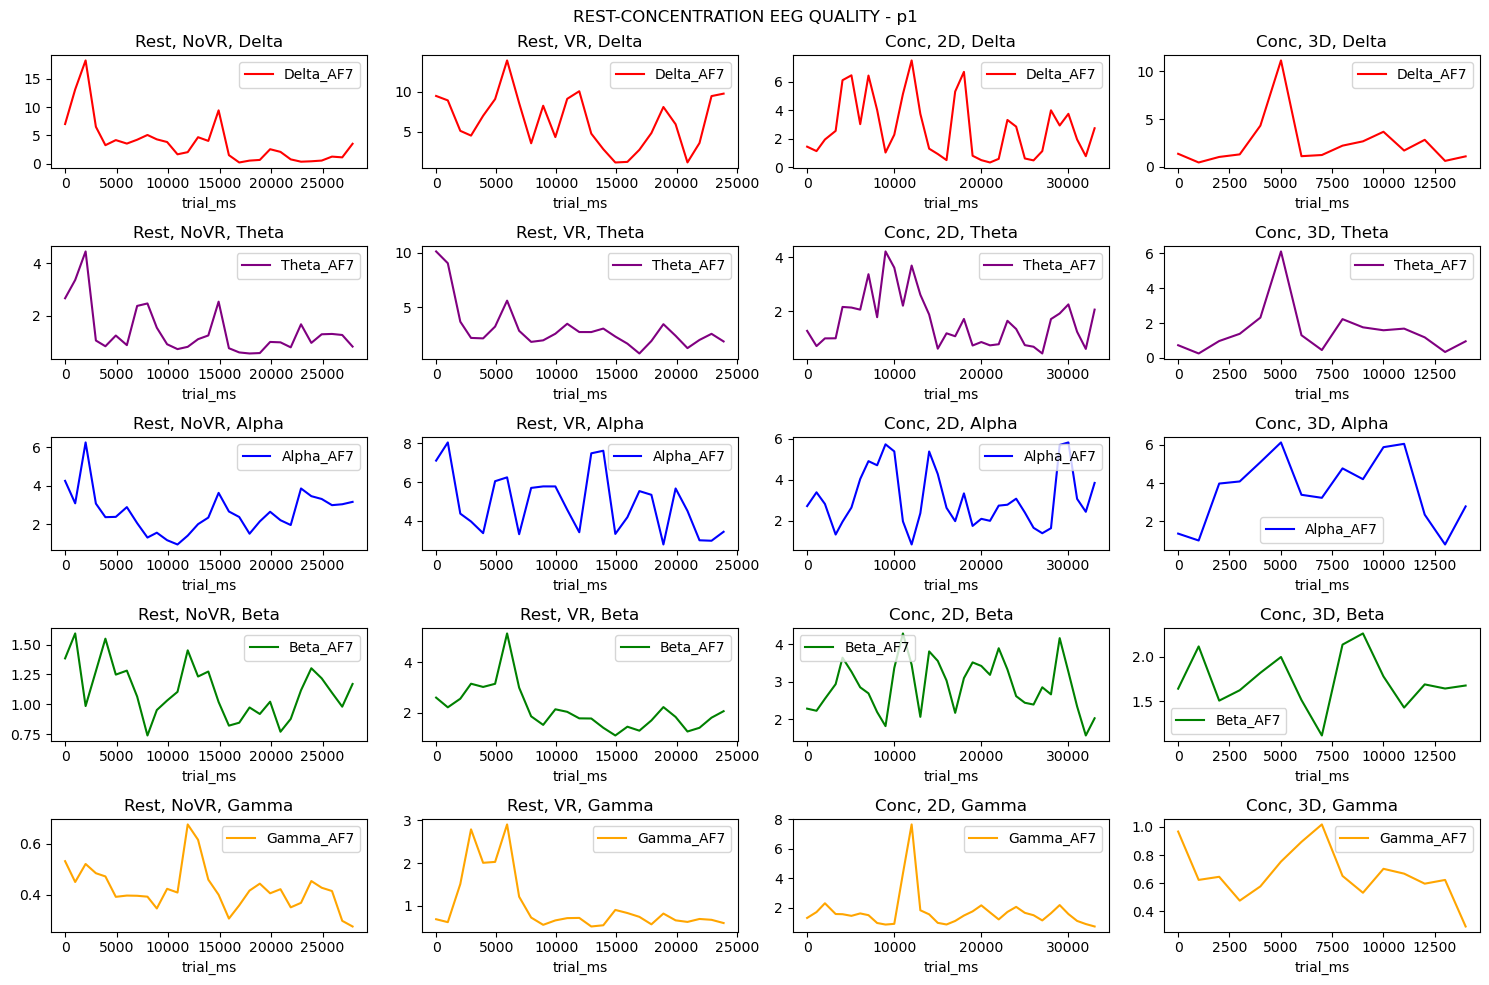

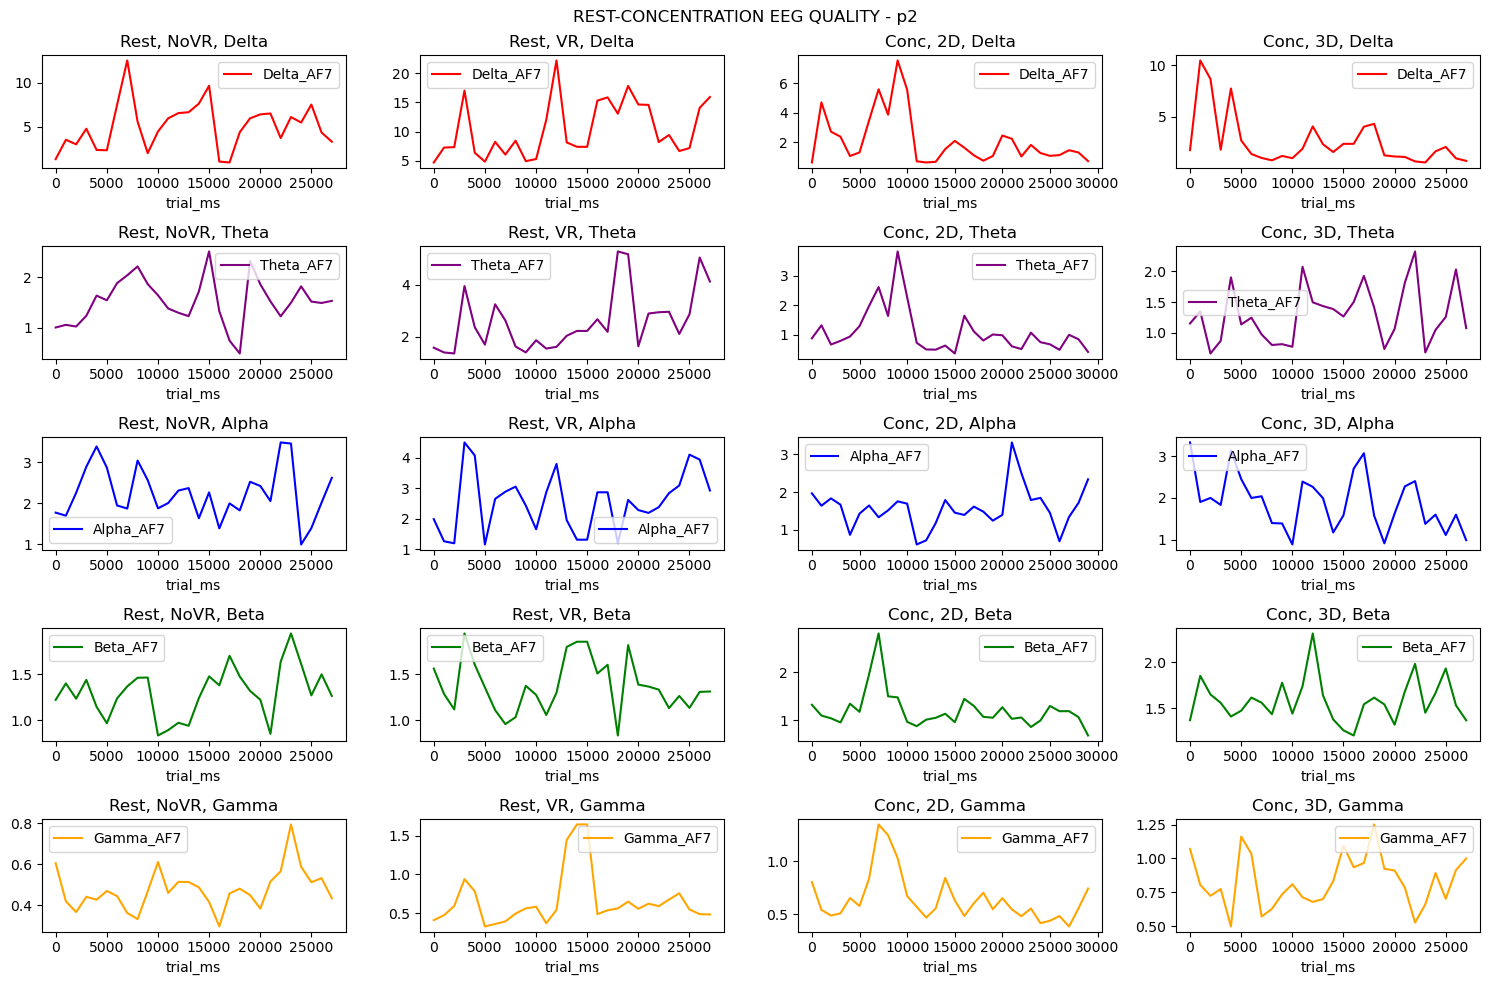

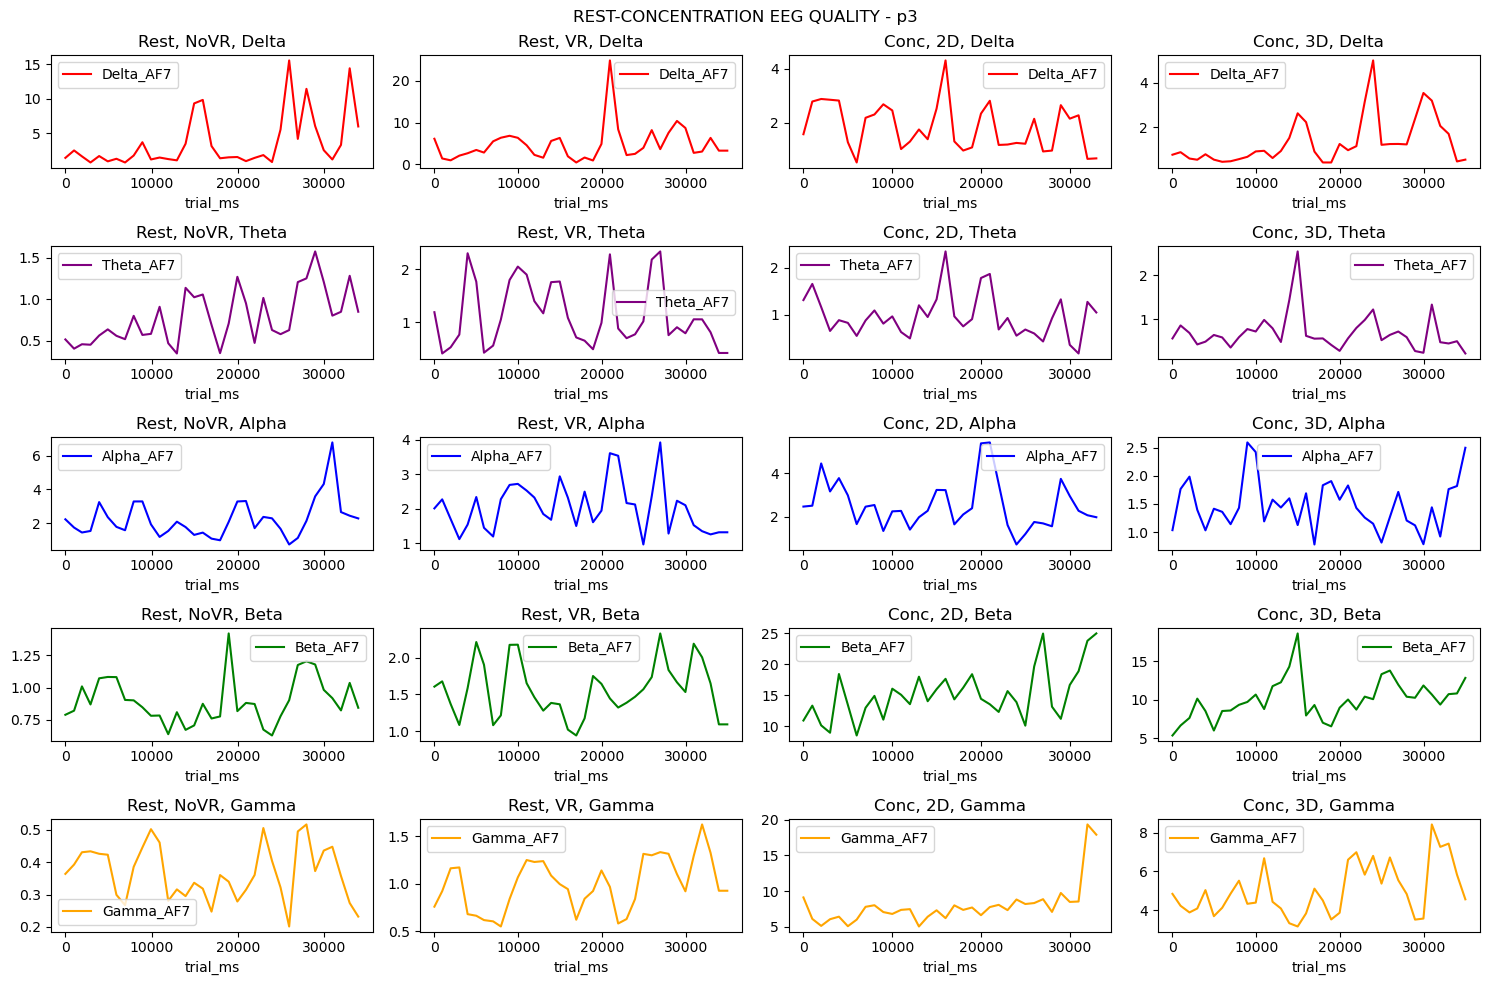

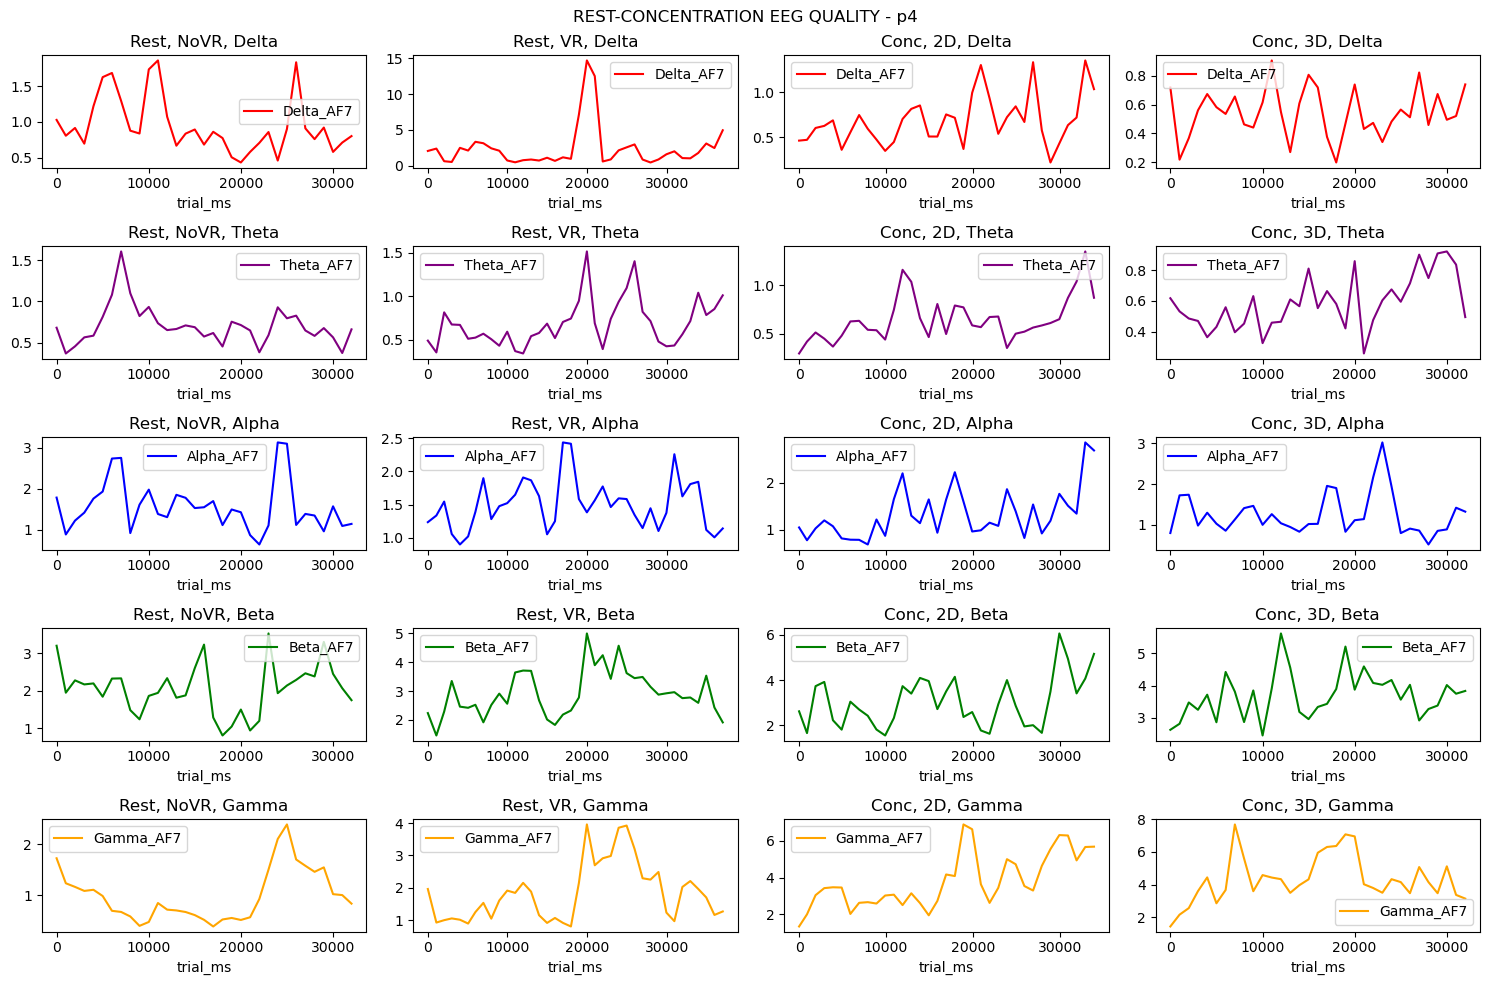

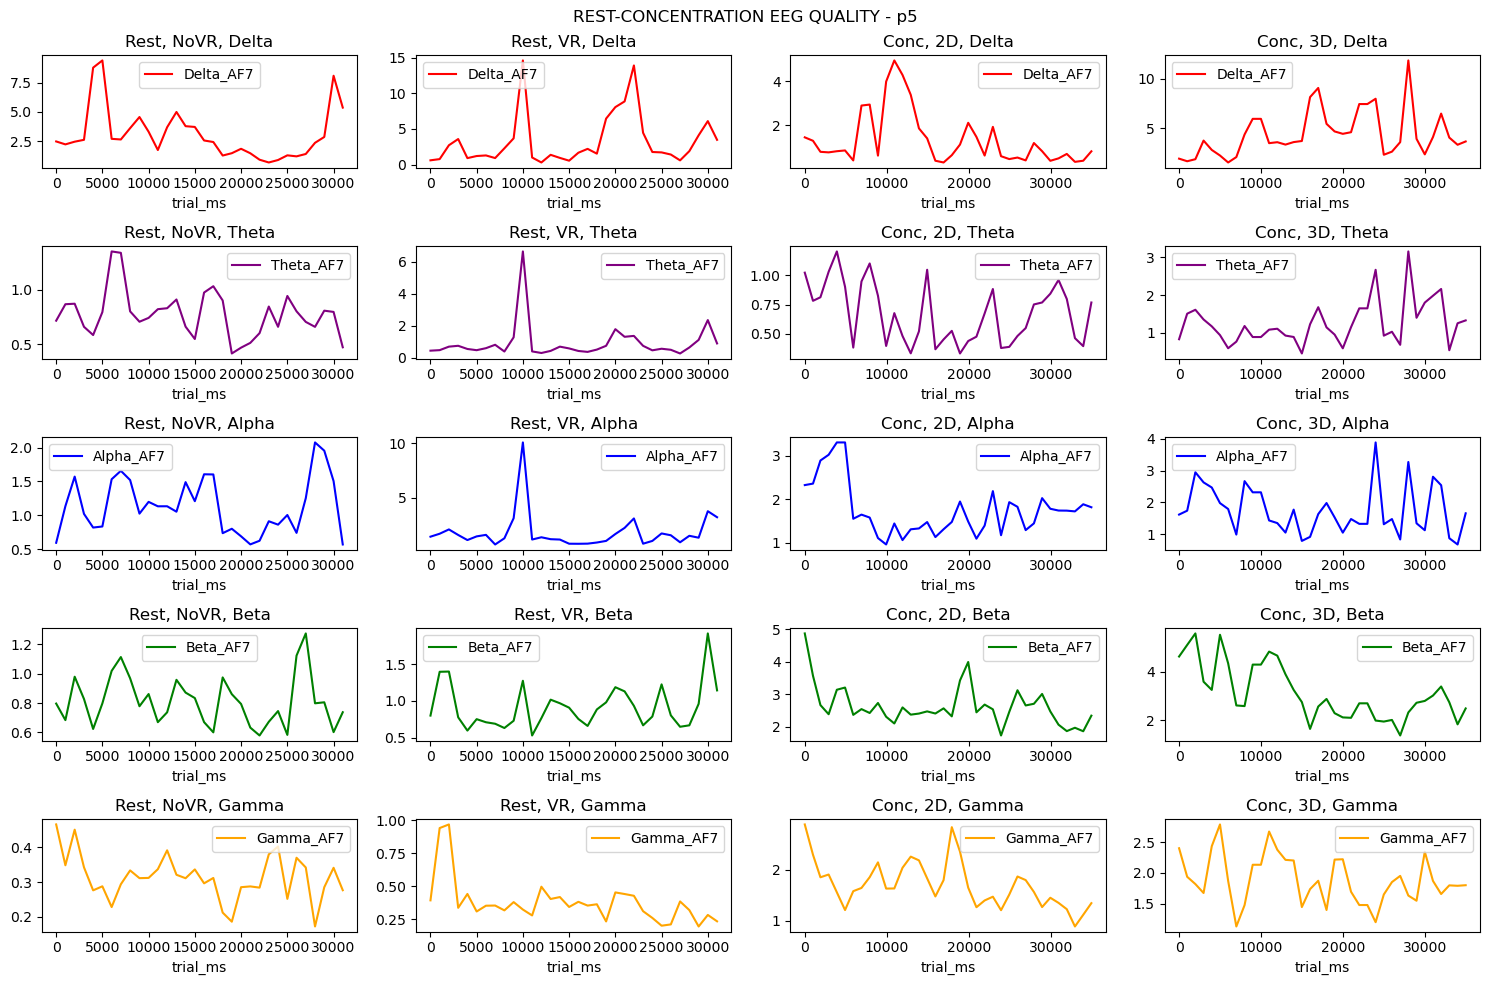

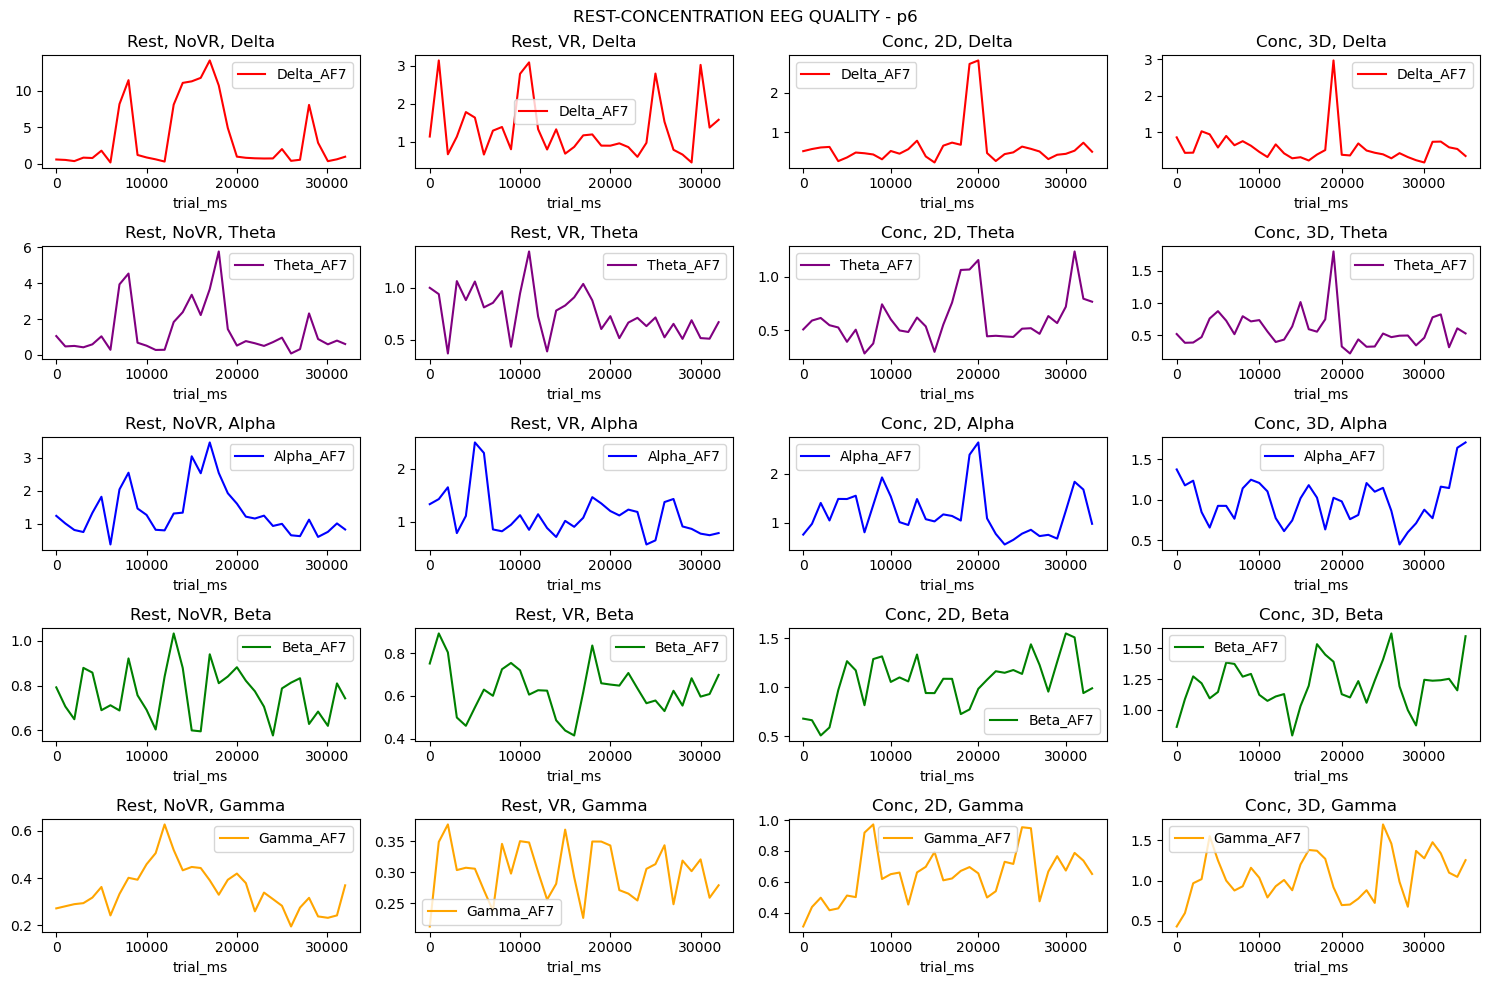

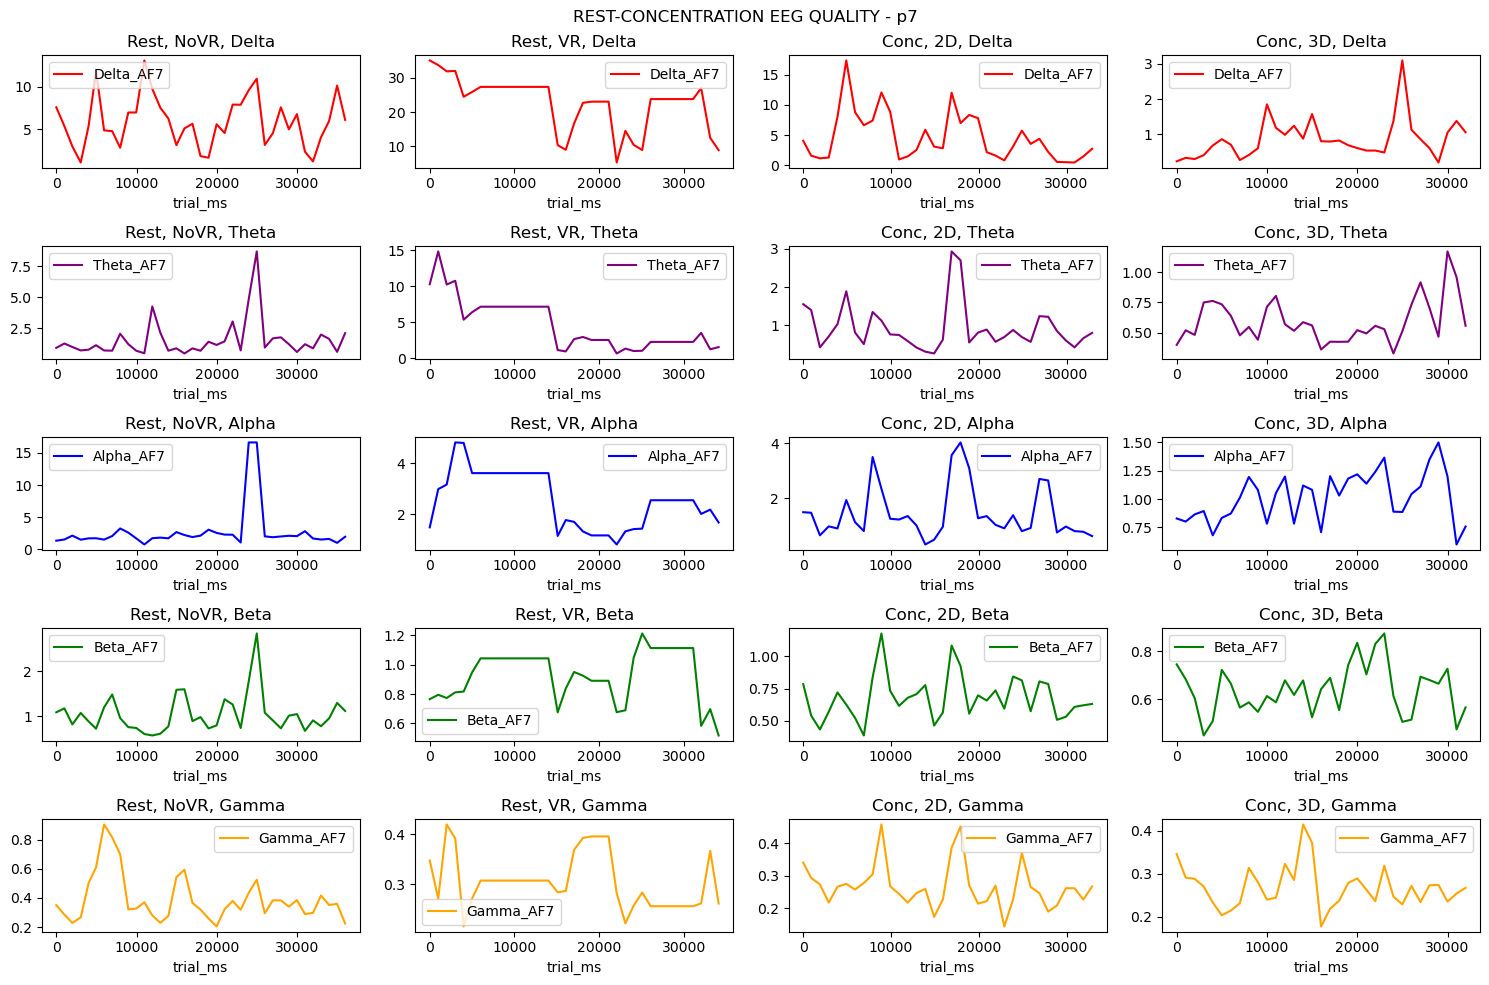

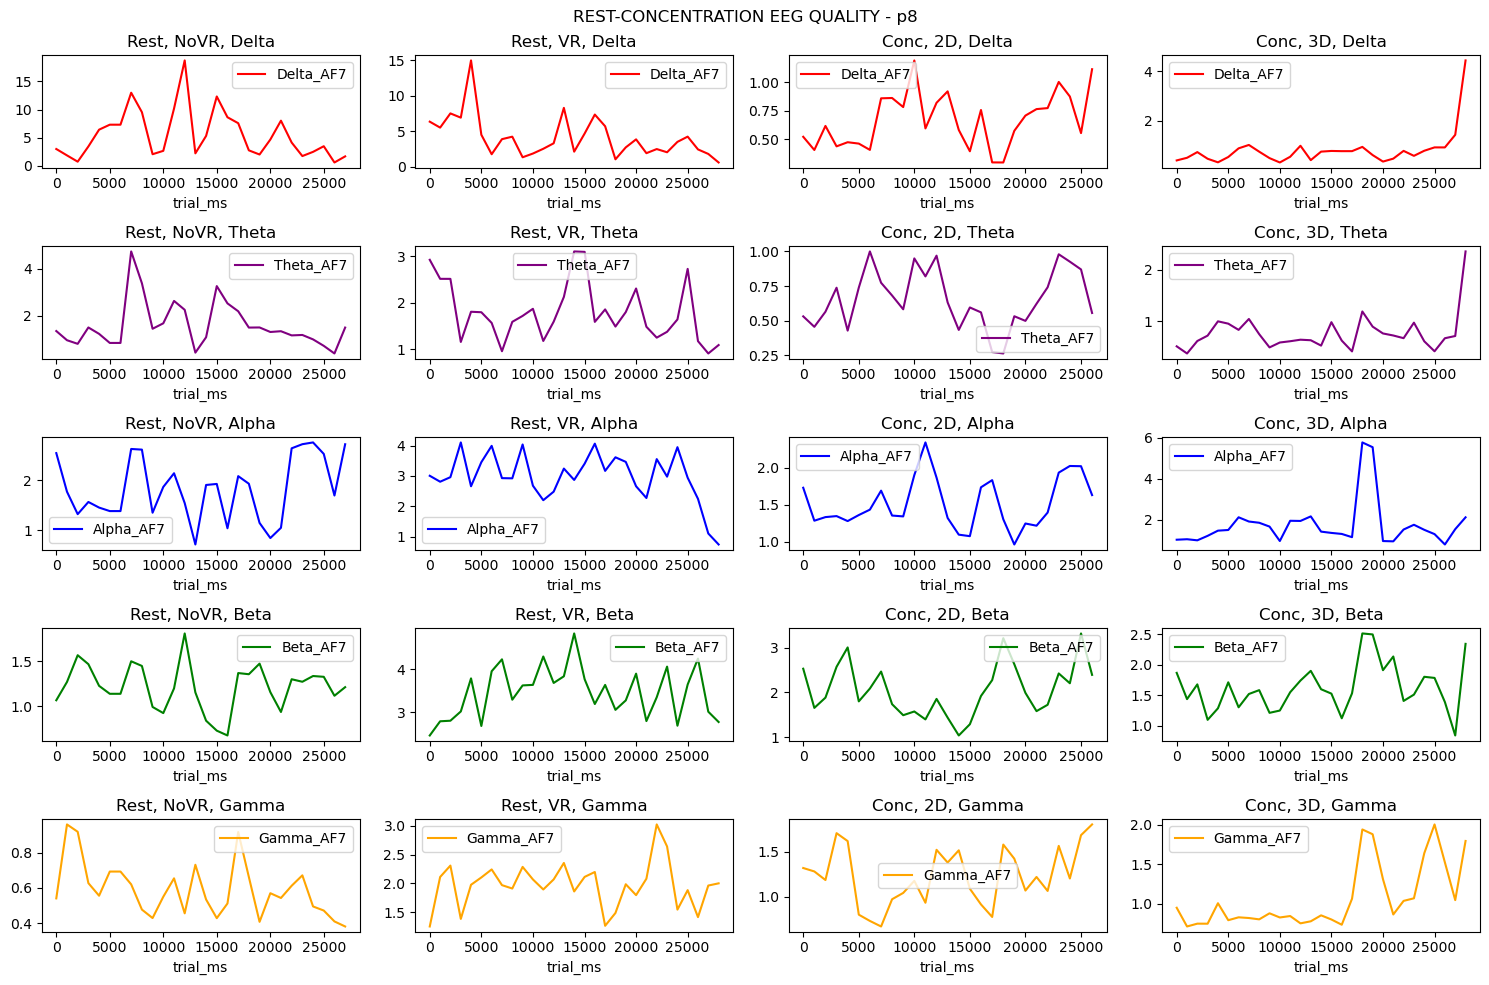

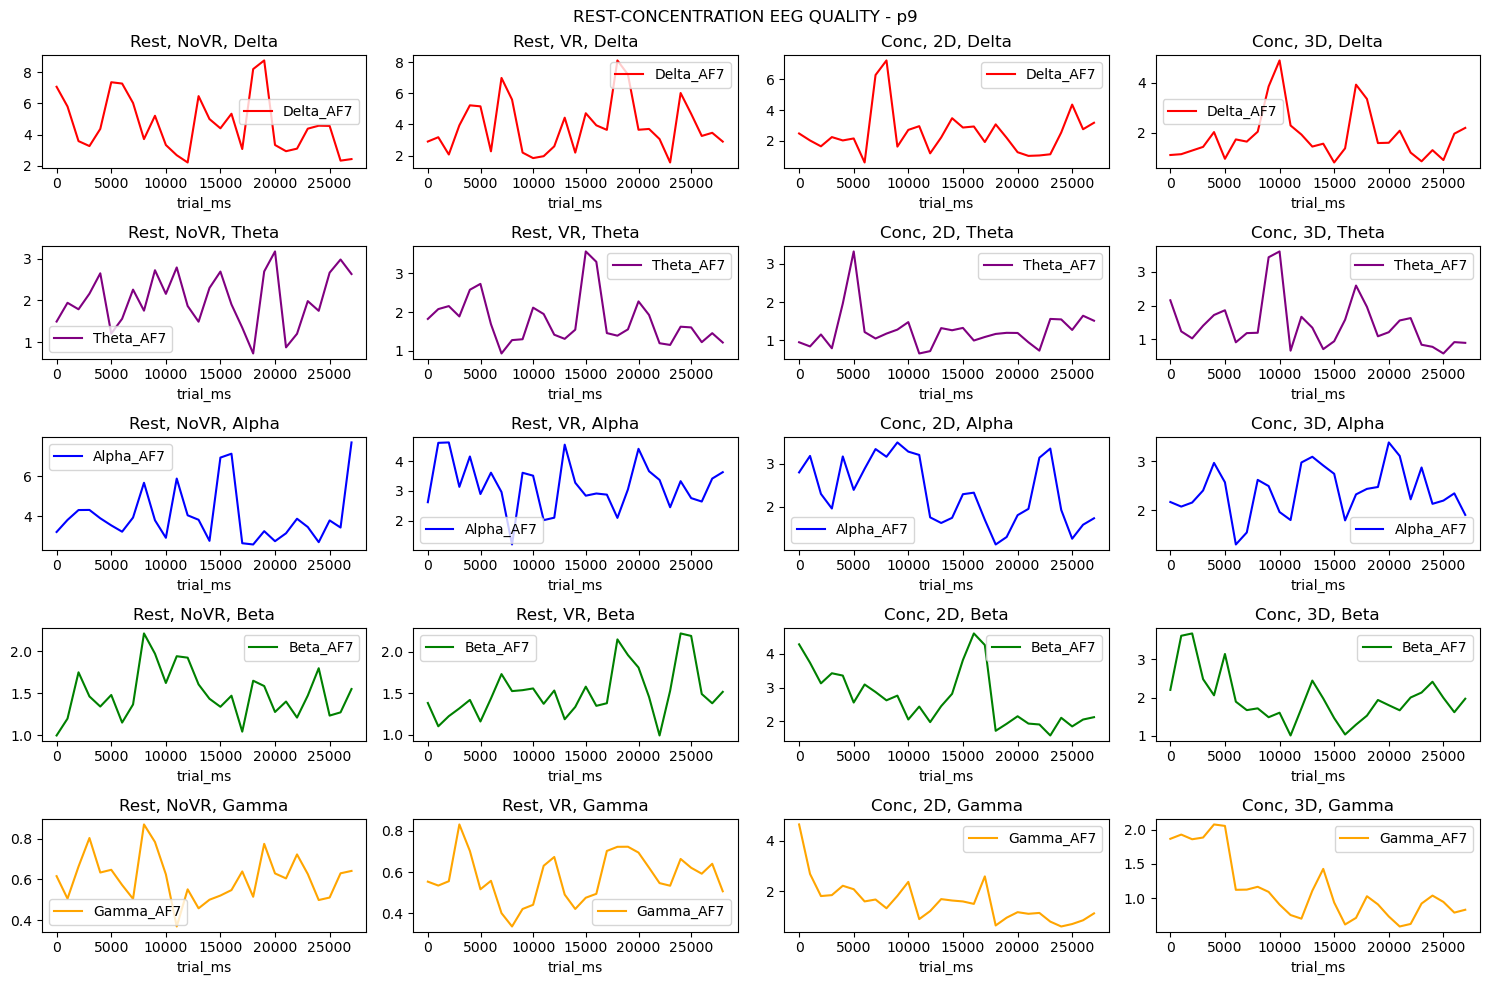

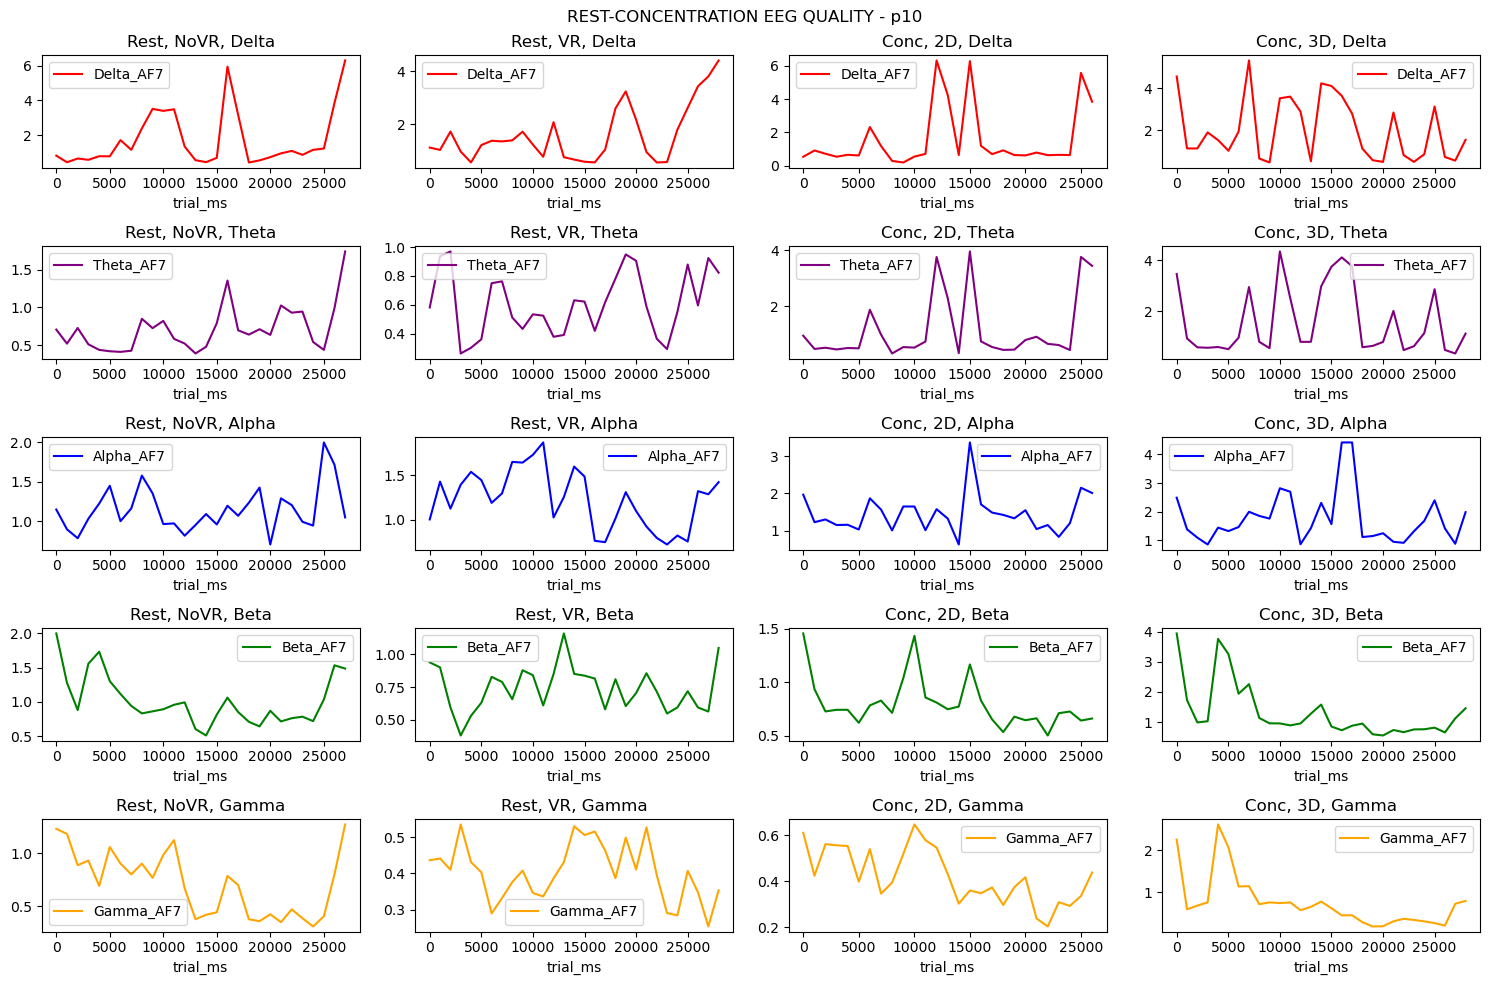

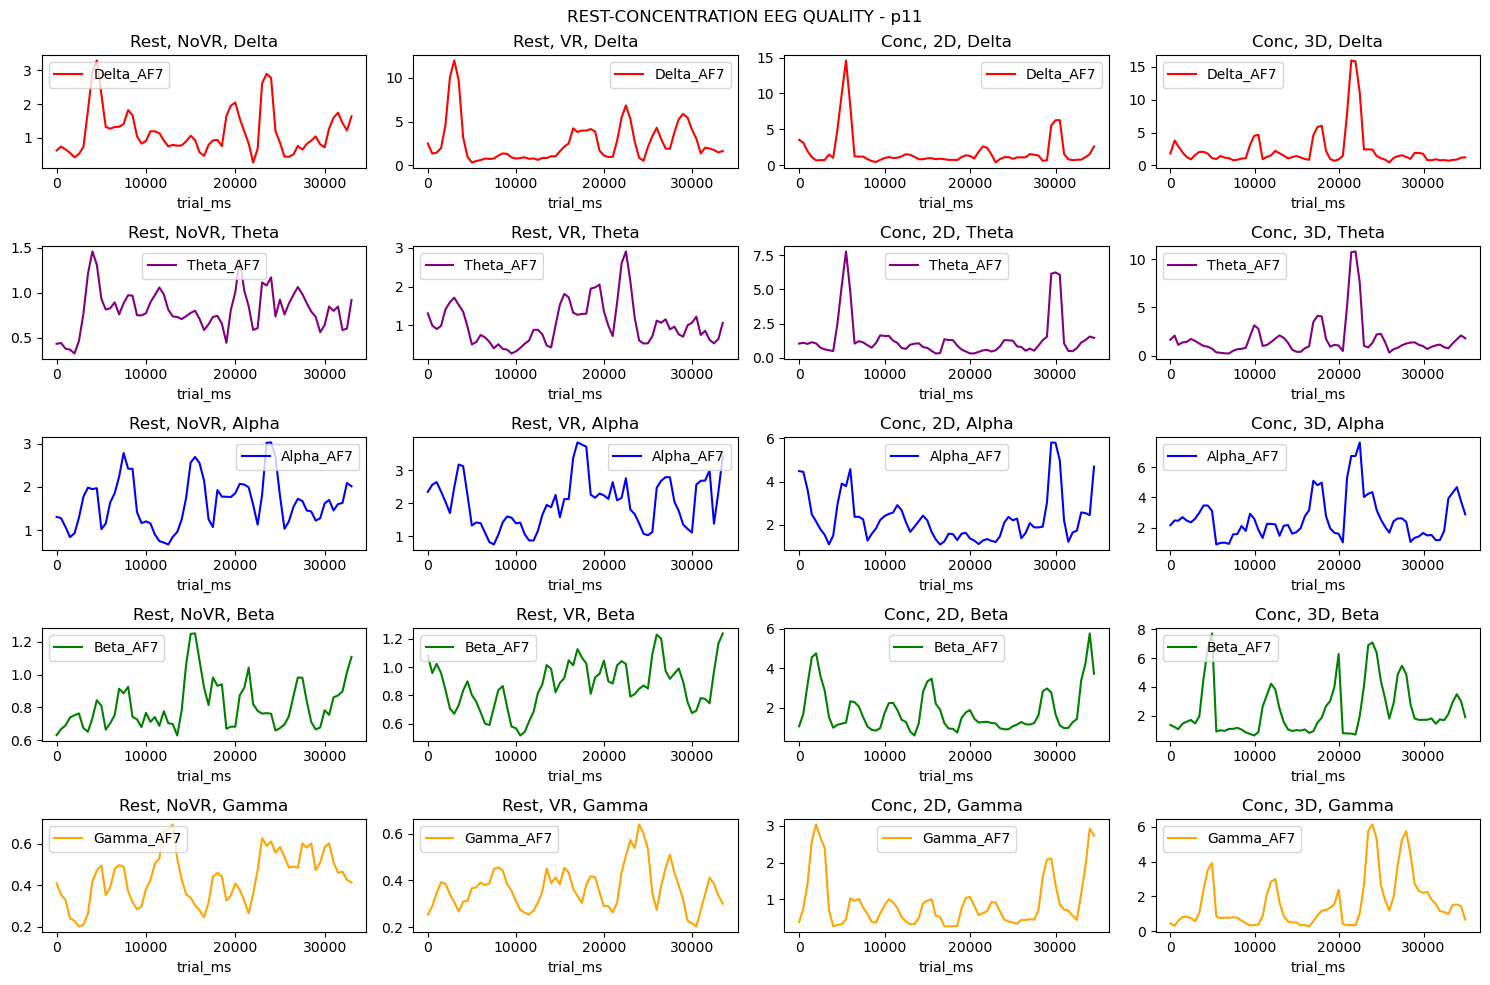

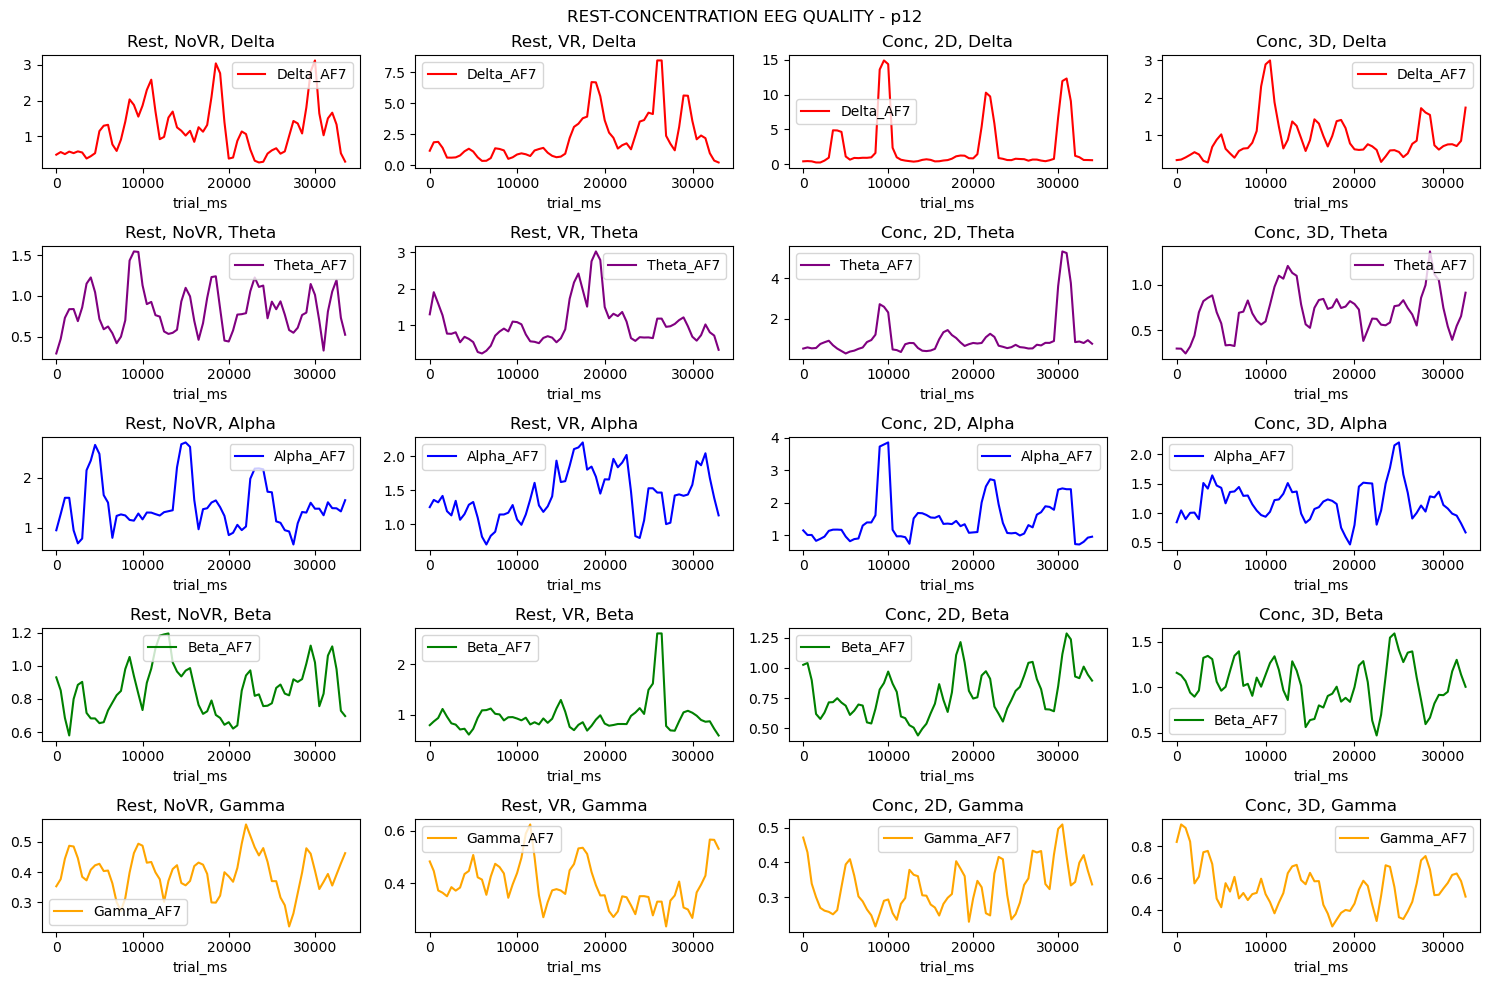

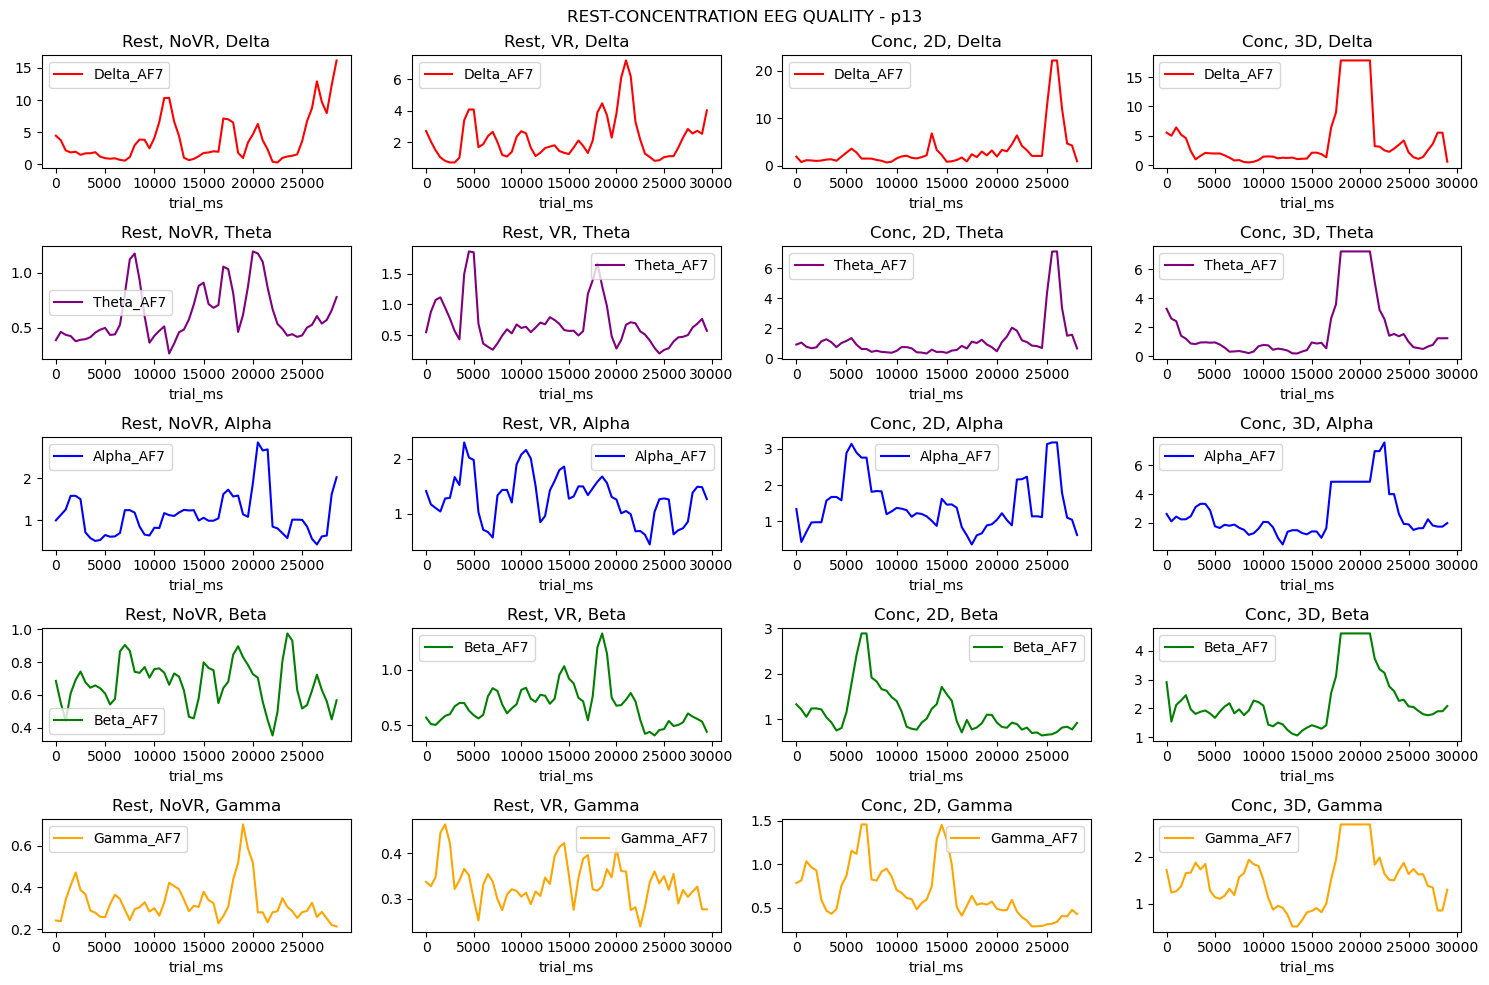

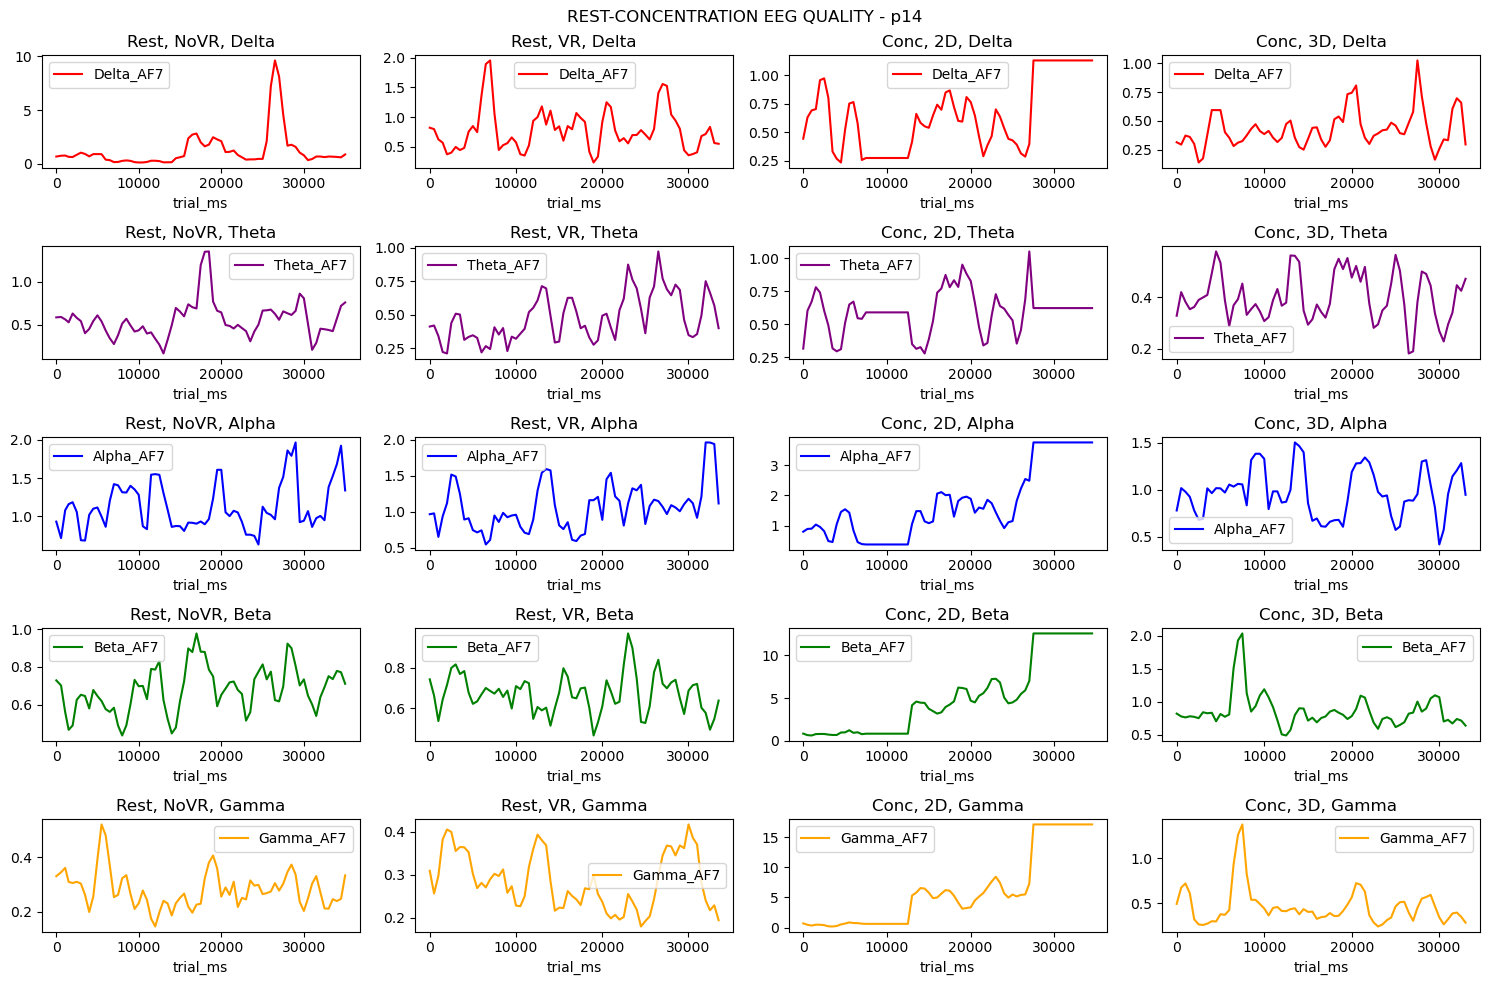

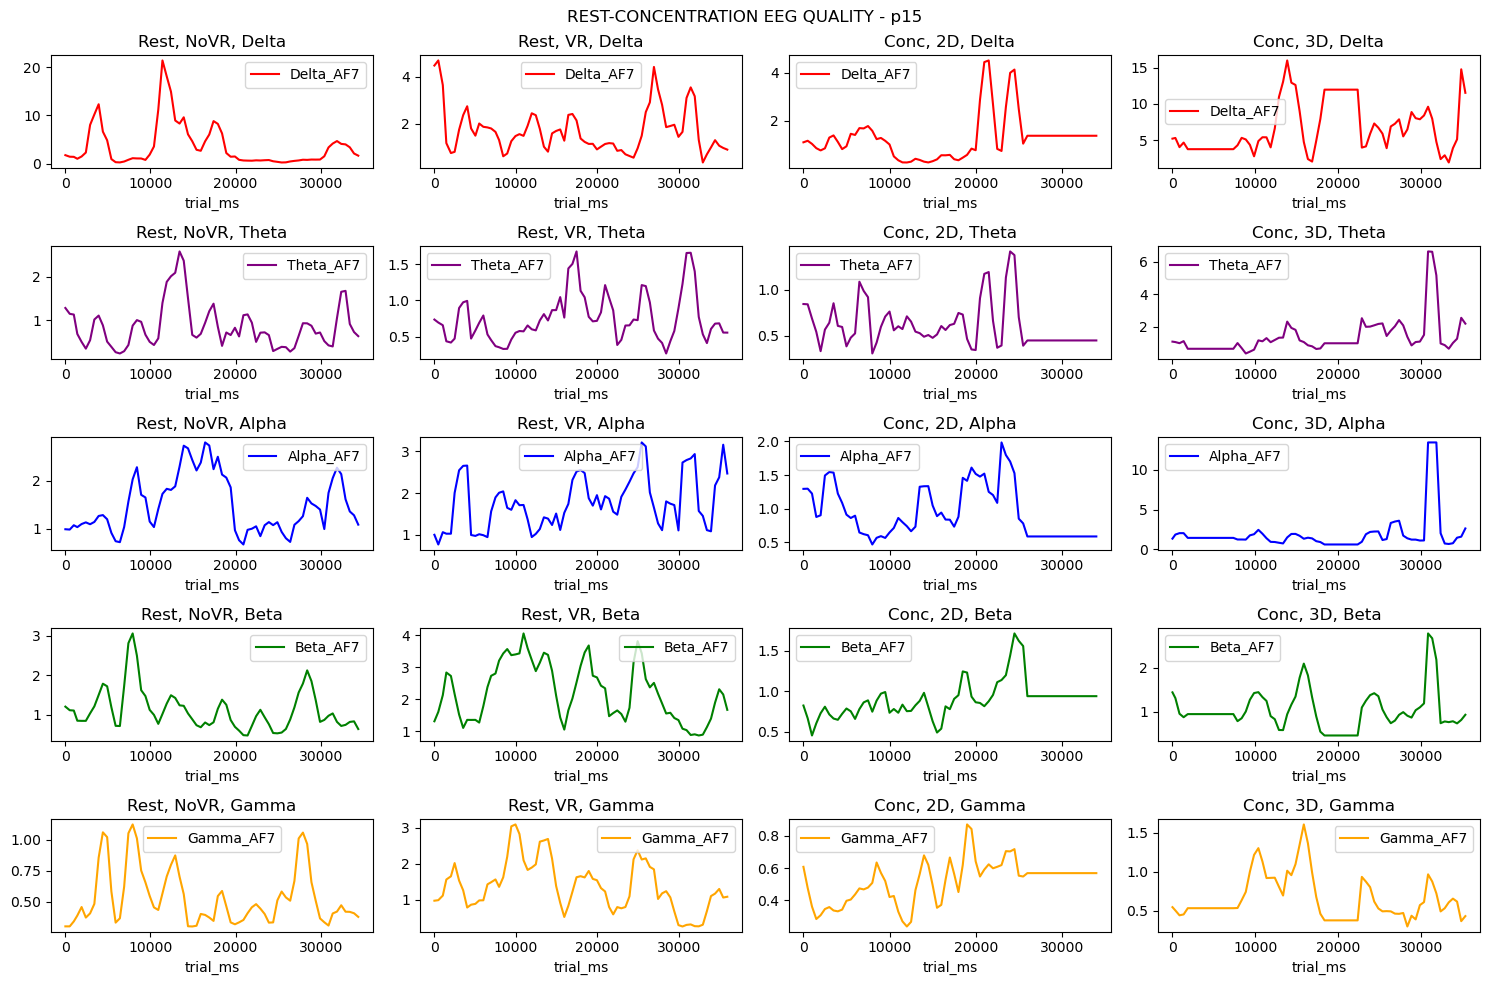

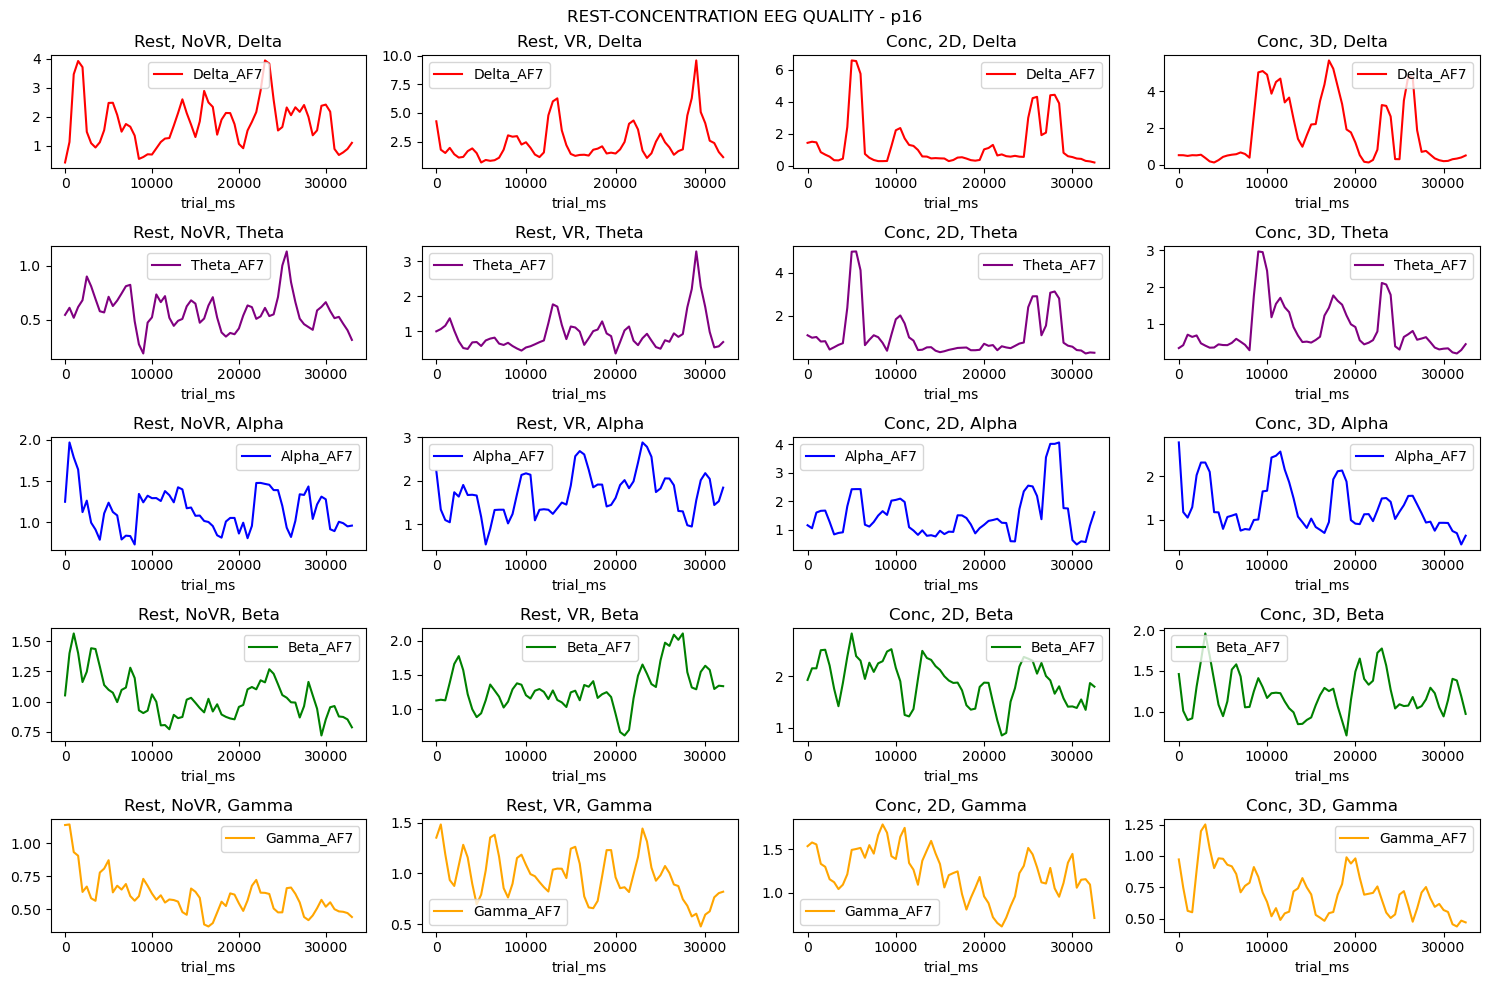

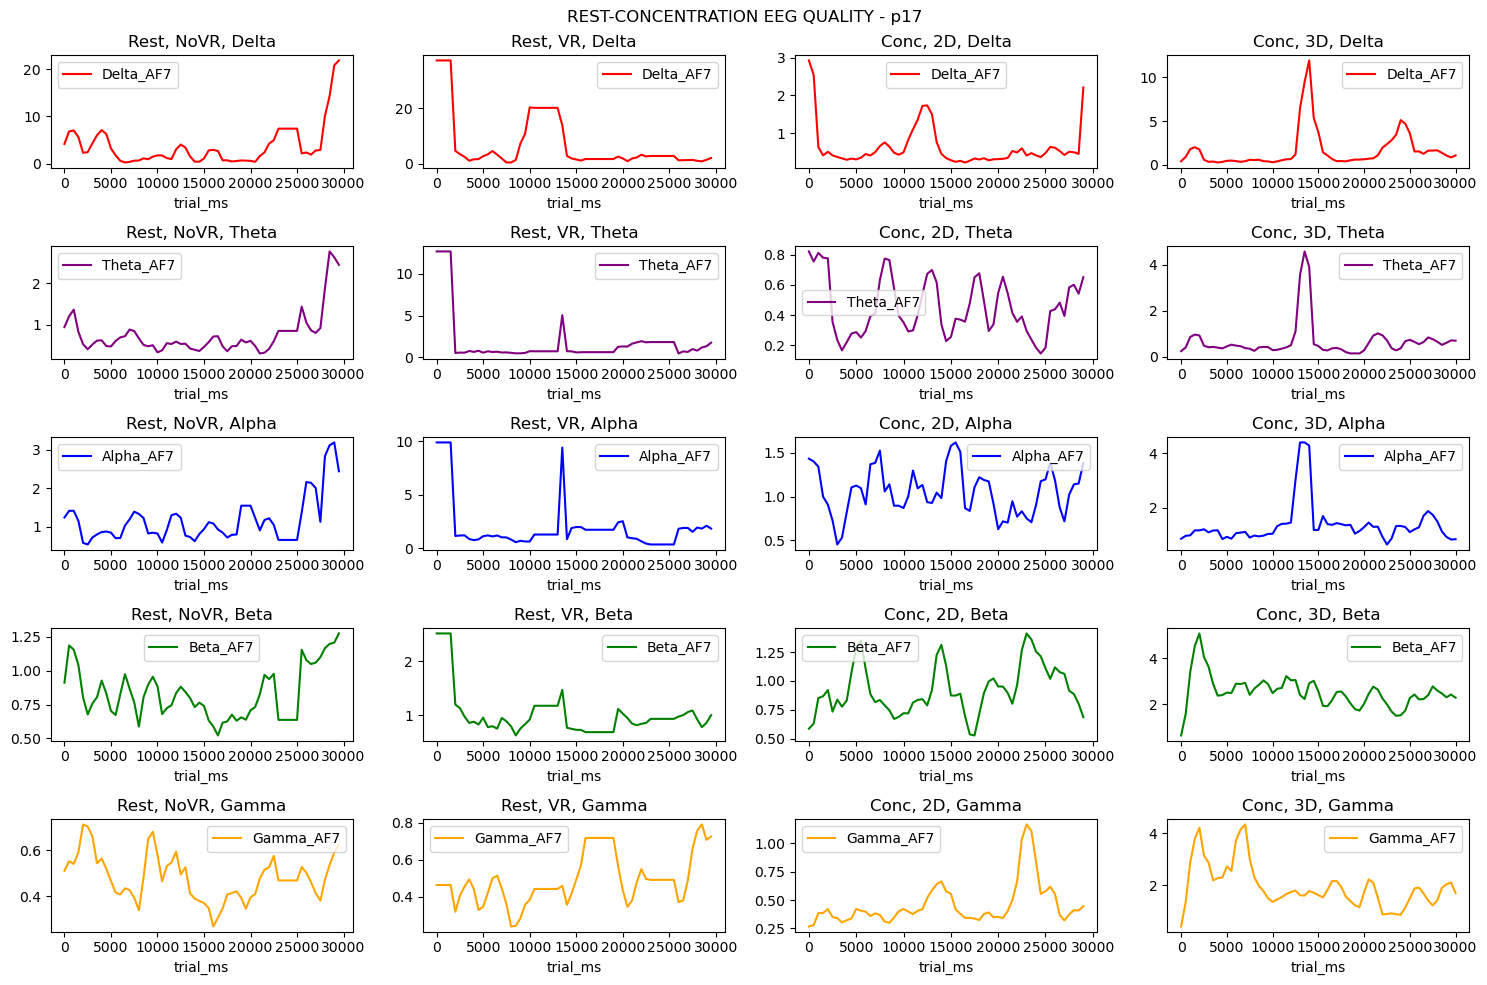

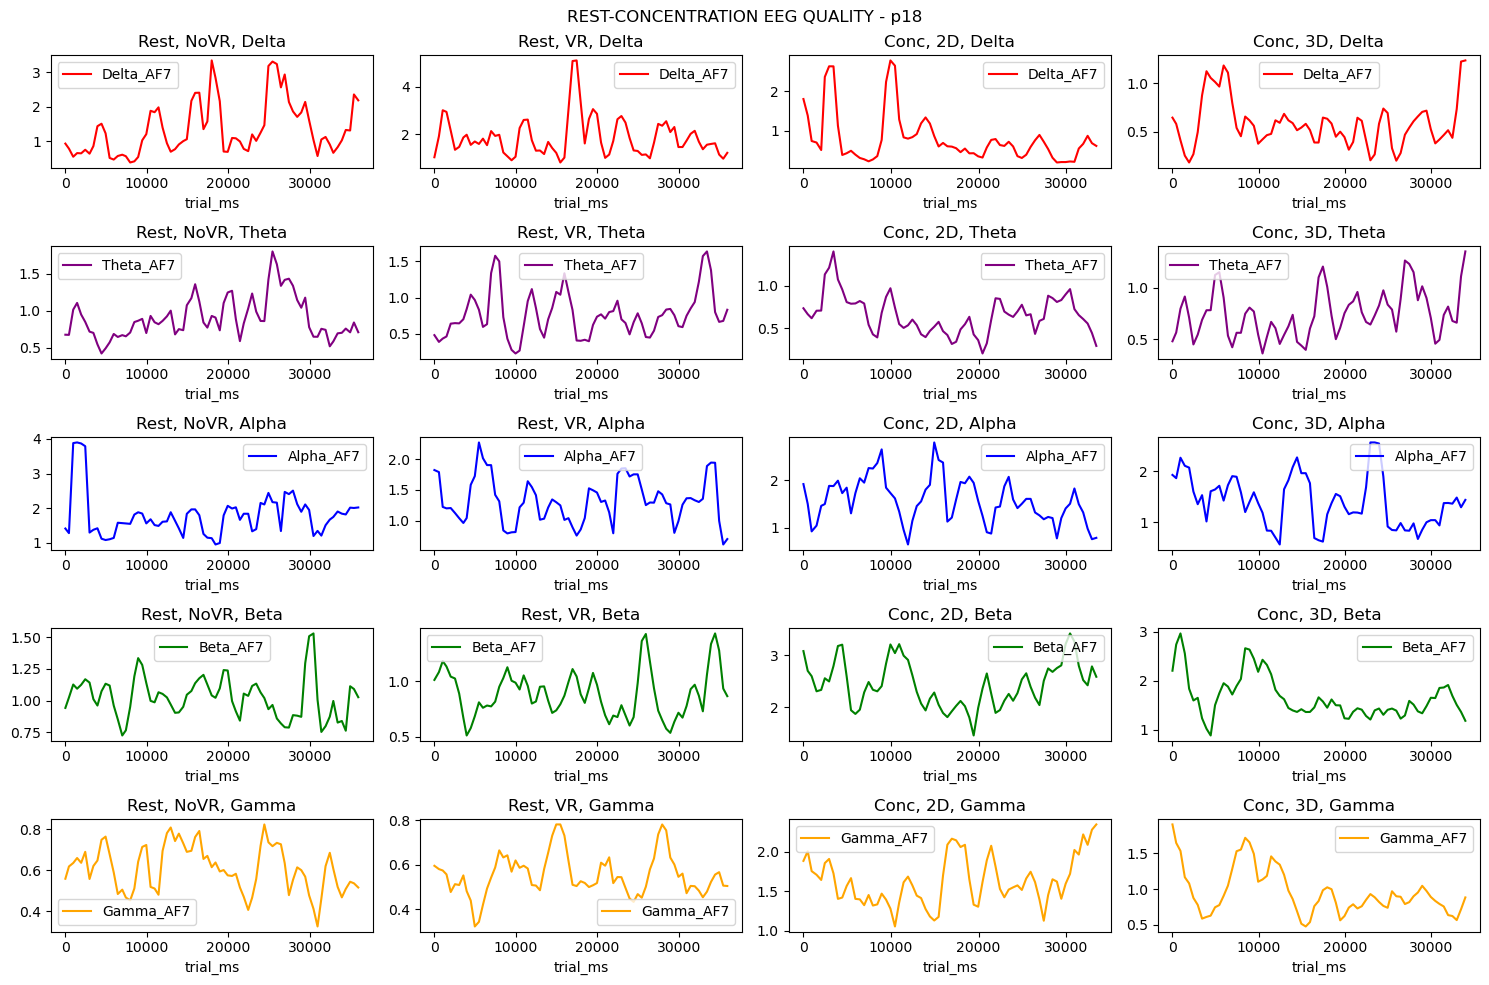

In [6]:
for pid in participants_df.participant.unique():
    plot_eeg(
        df = rc_df, 
        participant_id = pid, 
        output_filepath = os.path.join(_OUTPUT_DIR, f'{pid}-restconc.png'))

## 2.3 Filtering Participants

Participants that must be removed from analysis:

* __P7:__ Rest VR data plateaus often in all frequency bands
* __P13:__ Plateauing in Concentration 3D state.
* __P14:__ Plateauing in Concentration 2D state.
* __P15:__ Plateauing in odd places across all bands during concentration
* __P17:__ Plateauing across all frequency bands during Rest+VR

In [7]:
# stats about this population
rc_filtered_df = filter_out_participants(rc_df, participant_list=['p7','p13','p14','p15','p17'], neural_list=['Yes'])
participant_stats(rc_filtered_df)

### Sex Statistics:

sex
Female    6
Male      6
Name: count, dtype: int64


### VR Statistics:

vr_experience
Yes    9
No     3
Name: count, dtype: int64 

vr_frequency
I use VR sparingly or irregularly (ex. few times a year)        4
I had at least one experience in VR (ex. one-off situations)    4
I use VR frequently (ex. at least once a week)                  1
Name: count, dtype: int64 

vr_sickness
I never experienced simulator sickness in VR                            6
Depending on the virtual content, I sometimes get simulator sickness    2
I used to experience simulator sickness in VR, but not anymore          1
Name: count, dtype: int64


### Age Statistics:

age
24    4
25    3
23    2
41    1
32    1
22    1
Name: count, dtype: int64 

Age Mean: 26.0
Age Median: 24.0
Age SD: 5.34279463815095


### Vision Statistics:

corrective_vision
Yes, I have corrective vision         9
No, I do not have corrected vision    3
Name: count, dtype: int64 

vision_condition
I had Myopia and Astigmatism, but I had a corrective surgery - SMILE.    1
My glasses correct for some small amount of astigmatism.                 1
Name: count, dtype: int64


### Neural Statistics:

neural_diagnosis
No    12
Name: count, dtype: int64 

Series([], Name: count, dtype: int64)


### Participant Data:

participant    AUX_RIGHT    AUX_LEFT  Accelerometer_X  Accelerometer_Y  \
0           p1   656.373626         NaN        -0.184448         0.068359   
1          p10   678.131868         NaN        -0.181580         0.154846   
2          p11   914.652015         NaN        -0.141846         0.092285   
3          p12   861.465201         NaN        -0.175476         0.129761   
4          p16   804.249084  645.091575        -0.335510        -0.000732   
5          p18   895.714286  745.018315        -0.139893         0.104370   
6           p2   734.945055         NaN        -0.123108         0.176514   
7           p3   744.615385         NaN         0.033936         0.038818   
8           p4   650.732601         NaN        -0.214172         0.097656   
9           p5  1014.981685         NaN        -0.389221         0.087341   
10          p6   787.728938         NaN        -0.000977         0.048279   
11          p8   719.633700         NaN        -0.110229         0.074280   

    Accelerometer_Z    Gyro_X    Gyro_Y    Gyro_Z  HeadBandOn  ...     sex  \
0          0.980225  0.074768 -1.114044 -0.119629         1.0  ...  Female   
1          0.988892  2.437439 -2.871094  0.538330         1.0  ...  Female   
2          1.007812  2.452393 -1.600037 -0.373840         1.0  ...    Male   
3          0.990417  2.437439 -0.949554  1.091614         1.0  ...  Female   
4          0.934326 -0.515900 -1.914062  1.024323         1.0  ...    Male   
5          0.982910  1.495361 -2.474823  1.428070         1.0  ...    Male   
6          0.982178 -0.074768 -0.994415 -0.523376         1.0  ...    Male   
7          1.017273  2.272949 -2.093506  0.201874         1.0  ...  Female   
8          0.982544  2.594452 -1.099091  0.157013         1.0  ...  Female   
9          0.936401  3.013153 -1.734619  0.530853         1.0  ...    Male   
10         1.015564  2.773895 -0.710297  0.986938         1.0  ...    Male   
11         1.008484  2.811279 -2.572021 -0.157013         1.0  ...  Female   

    vr_experience                                       vr_frequency  \
0              No                                               None   
1             Yes  I use VR sparingly or irregularly (ex. few tim...   
2              No                                               None   
3             Yes  I had at least one experience in VR (ex. one-o...   
4             Yes  I had at least one experience in VR (ex. one-o...   
5              No                                               None   
6             Yes  I had at least one experience in VR (ex. one-o...   
7             Yes  I use VR sparingly or irregularly (ex. few tim...   
8             Yes     I use VR frequently (ex. at least once a week)   
9             Yes  I had at least one experience in VR (ex. one-o...   
10            Yes  I use VR sparingly or irregularly (ex. few tim...   
11            Yes  I use VR sparingly or irregularly (ex. few tim...   

                                          vr_sickness  \
0                                                None   
1   Depending on the virtual content, I sometimes ...   
2                                                None   
3        I never experienced simulator sickness in VR   
4        I never experienced simulator sickness in VR   
5                                                None   
6        I never experienced simulator sickness in VR   
7        I never experienced simulator sickness in VR   
8        I never experienced simulator sickness in VR   
9   I used to experience simulator sickness in VR,...   
10       I never experienced simulator sickness in VR   
11  Depending on the virtual content, I sometimes ...   

                     corrective_vision vision_diagnosis  \
0        Yes, I have corrective vision               No   
1   No, I do not have corrected vision               No   
2        Yes, I have corrective vision              Yes   
3   No, I do not have corrected vision               No   
4        Yes

## 2.4 Extracting Medians

In [8]:
rcm_df = rc_filtered_df.groupby(["participant", "task", "task_type"], as_index=False).agg(_MEDIAN_AGGR_DICT)
display(rcm_df)


participant  task task_type  Delta_AF7  Delta_AF8  Delta_TP9  Delta_TP10  \
0           p1  conc        2d   2.421667   0.758858   2.721676    3.089107   
1           p1  conc        3d   1.365740   1.047261   2.769011    2.543855   
2           p1  rest      novr   3.287857   2.435449   2.763390    3.786698   
3           p1  rest        vr   5.954669   8.142710  17.684680   14.575367   
4          p10  conc        2d   0.684812   0.521281   1.310787    1.325072   
5          p10  conc        3d   1.531449   1.166611   1.399787    1.219144   
6          p10  rest      novr   1.016849   0.924834   3.442209    3.369089   
7          p10  rest        vr   1.227582   1.564639   2.664064    3.007974   
8          p11  conc        2d   1.104815   2.374553   2.313977    1.697138   
9          p11  conc        3d   1.299964   2.706687   2.299820    2.639660   
10         p11  rest      novr   0.933819   1.294426   4.133210    3.253853   
11         p11  rest        vr   1.815453   1.536854   3.560186    3.118407   
12         p12  conc        2d   0.790178   0.924024   2.389361    2.882065   
13         p12  conc        3d   0.727543   0.750968   1.696628    2.117494   
14         p12  rest      novr   1.074141   1.176943   1.979521    2.644184   
15         p12  rest        vr   1.363466   1.349496   4.196003    3.364101   
16         p16  conc        2d   0.607971   0.791193   1.380996    0.834026   
17         p16  conc        3d   0.730487   0.853625   1.157680    1.246623   
18         p16  rest      novr   1.723087   1.357252   1.540960    1.605309   
19         p16  rest        vr   1.820033   1.646017   1.200716    1.457692   
20         p18  conc        2d   0.601837   0.584209   1.200729    0.950817   
21         p18  conc        3d   0.545202   0.698161   1.072662    0.841428   
22         p18  rest      novr   1.090410   1.040135   6.141018    6.266035   
23         p18  rest        vr   1.668221   1.440983   3.198265    2.953378   
24          p2  conc        2d   1.389354   1.024410   2.326306    3.120863   
25          p2  conc        3d   1.710619   1.393333   2.648801    2.443037   
26          p2  rest      novr   5.124917   6.799133   3.640935    2.396309   
27          p2  rest        vr   8.236878   3.788758   4.598924    3.815386   
28          p3  conc        2d   1.662857   1.313403   3.482685    7.420800   
29          p3  conc        3d   0.924215   0.748990   5.573614    2.242238   
30          p3  rest      novr   1.716235   1.651316   8.856311   45.588167   
31          p3  rest        vr   3.567250   3.120813   8.113113    6.174649   
32          p4  conc        2d   0.632373   1.444938  11.747395    1.881182   
33          p4  conc        3d   0.534943   0.875478   5.475603    1.952503   
34          p4  rest      novr   0.859322   1.157295   5.363078    3.536692   
35          p4  rest        vr   1.678386   5.931269  11.208743    3.639474   
36          p5  conc        2d   0.794338   1.964877   2.120122    1.975491   
37          p5  conc        3d   3.756987   3.222048   2.460659    2.160988   
38          p5  rest      novr   2.525982   1.797261   5.985848    4.779603   
39          p5  rest        vr   1.741036   3.514381   4.013788    5.339483   
40          p6  conc        2d   0.513856   0.494149   1.467539    1.393094   
41          p6  conc        3d   0.447560   0.451129   1.700293    1.386748   
42          p6  rest      novr   0.863976   0.687239   1.801453    1.729639   
43          p6  rest        vr   1.132475   1.630815   5.585042    6.268826   
44          p8  conc        2d   0.617387   0.481458   6.493757    2.072793   
45          p8  conc        3d   0.750727   0.658324   2.825632    2.224596   
46          p8  rest      novr   3.818781   3.623947   6.028109    6.404499   
47          p8  rest        vr   3.492866   1.290986   3.496320    3.333834   

    Theta_AF7  Theta_AF8  Theta_TP9  ...  Alpha_TP9  Alpha_TP10   Beta_AF7  \
0    1.489893   0.737490   5.086987  ...  22.364547  

# 3. Tests for Significance

In [9]:
def subtract_rows(group):
    return group[_POWER_COLS].iloc[1] - group[_POWER_COLS].iloc[0]

def test_wilcoxon(cols, df):
    latex_output = []
    for colname in cols:
        d = df[colname].tolist()
        twoside_res = wilcoxon(d)
        greater_res = wilcoxon(d, alternative='greater')
        less_res = wilcoxon(d, alternative='less')
        print(f"{colname}\t2S: {twoside_res.statistic}/{twoside_res.pvalue} \t|G: {greater_res.statistic}/{greater_res.pvalue}  \t|L: {less_res.statistic}/{less_res.pvalue}")
        latex_output.append(f'{colname}\t& {int(twoside_res.statistic)}, {round(twoside_res.pvalue,3)} & {int(greater_res.statistic)}, {round(greater_res.pvalue,3)} | {round(less_res.pvalue,3)} \\\\')
    print("--------------")
    print('\n'.join(latex_output)) 

## 3.1 Influence of VR HMD Presence during Resting

In [10]:
rest_df = rcm_df[rcm_df['task'] == 'rest']
display(rest_df)
restdiff_df = rest_df.groupby(['participant'], as_index=False).apply(subtract_rows)
display(restdiff_df)
test_wilcoxon(_POWER_COLS, restdiff_df)

participant  task task_type  Delta_AF7  Delta_AF8  Delta_TP9  Delta_TP10  \
2           p1  rest      novr   3.287857   2.435449   2.763390    3.786698   
3           p1  rest        vr   5.954669   8.142710  17.684680   14.575367   
6          p10  rest      novr   1.016849   0.924834   3.442209    3.369089   
7          p10  rest        vr   1.227582   1.564639   2.664064    3.007974   
10         p11  rest      novr   0.933819   1.294426   4.133210    3.253853   
11         p11  rest        vr   1.815453   1.536854   3.560186    3.118407   
14         p12  rest      novr   1.074141   1.176943   1.979521    2.644184   
15         p12  rest        vr   1.363466   1.349496   4.196003    3.364101   
18         p16  rest      novr   1.723087   1.357252   1.540960    1.605309   
19         p16  rest        vr   1.820033   1.646017   1.200716    1.457692   
22         p18  rest      novr   1.090410   1.040135   6.141018    6.266035   
23         p18  rest        vr   1.668221   1.440983   3.198265    2.953378   
26          p2  rest      novr   5.124917   6.799133   3.640935    2.396309   
27          p2  rest        vr   8.236878   3.788758   4.598924    3.815386   
30          p3  rest      novr   1.716235   1.651316   8.856311   45.588167   
31          p3  rest        vr   3.567250   3.120813   8.113113    6.174649   
34          p4  rest      novr   0.859322   1.157295   5.363078    3.536692   
35          p4  rest        vr   1.678386   5.931269  11.208743    3.639474   
38          p5  rest      novr   2.525982   1.797261   5.985848    4.779603   
39          p5  rest        vr   1.741036   3.514381   4.013788    5.339483   
42          p6  rest      novr   0.863976   0.687239   1.801453    1.729639   
43          p6  rest        vr   1.132475   1.630815   5.585042    6.268826   
46          p8  rest      novr   3.818781   3.623947   6.028109    6.404499   
47          p8  rest        vr   3.492866   1.290986   3.496320    3.333834   

    Theta_AF7  Theta_AF8  Theta_TP9  ...  Alpha_TP9  Alpha_TP10  Beta_AF7  \
2    1.072979   1.216981   4.548527  ...  20.741302   13.581963  1.097606   
3    2.572103   3.007136   7.726297  ...  37.601783   33.735576  1.850552   
6    0.667908   0.602886   1.646317  ...   8.387506    6.316010  0.885896   
7    0.587086   0.575648   2.098506  ...  12.344325   11.432602  0.717564   
10   0.796777   1.017527   3.656371  ...  19.804172   13.486021  0.762611   
11   0.970480   0.771441   3.484675  ...  14.977300   11.090215  0.874181   
14   0.773128   0.705856   2.103653  ...   7.592356   10.048061  0.840602   
15   0.831641   0.999404   2.704076  ...   8.656379    9.240985  0.884196   
18   0.567124   0.472542   1.441634  ...   7.455117    8.433652  0.996009   
19   0.784579   0.667331   1.095837  ...   5.744205    6.116820  1.272707   
22   0.843137   0.638418   2.180044  ...   7.605335    9.027988  1.025204   
23   0.728943   0.819291   1.631875  ...   8.418991   10.813380  0.868581   
26   1.519524   3.107917   1.951336  ...   2.990371    2.652449  1.296405   
27   2.228799   1.815560   2.029383  ...   2.657363    2.809827  1.321929   
30   0.690335   0.644613   3.746790  ...  18.955259   11.032357  0.867878   
31   1.002884   0.967701   3.860731  ...  11.647786   10.009457  1.550536   
34   0.667510   0.730517   2.799237  ...  12.472344   11.209037  2.066910   
35   0.672422   1.307664   4.681646  ...  11.948861   12.060945  2.774404   
38   0.795044   0.640830   1.429908  ...   4.250179    4.952356  0.797074   
39   0.581515   0.611990   1.635794  ...   4.428987    4.986167  0.801489   
42   0.712998   0.671202   1.532385  ...   2.062381    2.735771  0.774580   
43   0.724552   0.741795   2.419073  ...   3.823632    5.508183  0.624964   
46   1.329842   1.188136   3.617668  ...  20.143688   21.245142  1.219946   
47   1.639412   0.861404   2.985276  ...  18.428197   15.237095  3.620767   

    Beta_AF8  Beta_TP9  Beta_TP10  Gamma_AF7  Gamma_AF8  Gamma_TP9  Gamma_TP10  
2   1.077801  4.1918

/var/folders/r7/zkk06b910nd7ysr86dhn0yqh0000gn/T/ipykernel_39649/786220593.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  restdiff_df = rest_df.groupby(['participant'], as_index=False).apply(subtract_rows)


participant  Delta_AF7  Delta_AF8  Delta_TP9  Delta_TP10  Theta_AF7  \
0           p1   2.666813   5.707260  14.921290   10.788668   1.499124   
1          p10   0.210733   0.639805  -0.778146   -0.361115  -0.080822   
2          p11   0.881634   0.242428  -0.573024   -0.135446   0.173703   
3          p12   0.289324   0.172553   2.216482    0.719917   0.058513   
4          p16   0.096946   0.288765  -0.340244   -0.147617   0.217455   
5          p18   0.577812   0.400849  -2.942753   -3.312657  -0.114194   
6           p2   3.111961  -3.010376   0.957990    1.419078   0.709275   
7           p3   1.851015   1.469497  -0.743198  -39.413518   0.312549   
8           p4   0.819064   4.773974   5.845665    0.102782   0.004912   
9           p5  -0.784946   1.717120  -1.972059    0.559881  -0.213529   
10          p6   0.268499   0.943576   3.783590    4.539188   0.011554   
11          p8  -0.325915  -2.332962  -2.531789   -3.070664   0.309570   

    Theta_AF8  Theta_TP9  Theta_TP10  Alpha_AF7  ...  Alpha_TP9  Alpha_TP10  \
0    1.790155   3.177770    5.369929   2.207686  ...  16.860481   20.153613   
1   -0.027238   0.452189   -0.362697   0.201329  ...   3.956819    5.116592   
2   -0.246086  -0.171696   -0.097588   0.439340  ...  -4.826872   -2.395806   
3    0.293548   0.600423   -0.685405   0.088898  ...   1.064024   -0.807076   
4    0.194789  -0.345797   -0.118989   0.555566  ...  -1.710912   -2.316832   
5    0.180874  -0.548169   -0.623265  -0.445186  ...   0.813657    1.785393   
6   -1.292357   0.078047    0.539515   0.482431  ...  -0.333008    0.157378   
7    0.323089   0.113941   -8.771193  -0.024049  ...  -7.307473   -1.022900   
8    0.577146   1.882410   -0.055751   0.046917  ...  -0.523482    0.851908   
9   -0.028840   0.205886    0.618587   0.298254  ...   0.178808    0.033811   
10   0.070594   0.886688    0.448698  -0.133335  ...   1.761251    2.772412   
11  -0.326733  -0.632391   -0.451862   1.138084  ...  -1.715491   -6.008047   

    Beta_AF7  Beta_AF8  Beta_TP9  Beta_TP10  Gamma_AF7  Gamma_AF8  Gamma_TP9  \
0   0.752946  2.933325  0.569271   0.609414   0.299436   1.806877   0.463750   
1  -0.168332  0.006342 -0.133784   1.276902  -0.327466  -0.056697   0.800057   
2   0.111570 -0.114480  0.276271   0.130413  -0.075666  -0.066989   0.432526   
3   0.043594  0.130388  0.363241   0.314422  -0.025139   0.094935   0.305453   
4   0.276698  0.286110 -0.020186  -0.175062   0.386476   0.189375   0.131478   
5  -0.156623 -0.111336  0.400109  -0.347097  -0.070715  -0.011057   0.628437   
6   0.025524  0.516468  0.195309   0.985041   0.092693   0.604238   0.259321   
7   0.682658  0.859667  0.299161  -1.798141   0.594868   0.634945   0.592133   
8   0.707494  0.234856 -0.727123  -0.406357   0.920783  -0.041805   0.730507   
9   0.004415  0.042954  0.128559   0.145807   0.040332  -0.012861   0.347838   
10 -0.149616 -0.011323 -0.248475   0.098123  -0.029191   0.042903  -0.139305   
11  2.400821  1.989529  1.339508   1.622976   1.432485   1.765228   1.413263   

    Gamma_TP10  
0     0.447862  
1     1.235123  
2     0.184855  
3     0.386610  
4     0.125178  
5     0.019356  
6     0.301257  
7     0.146959  
8     0.558961  
9     0.196134  
10   -0.385098  
11    1.339963  

[12 rows x 21 columns]

Delta_AF7	2S: 12.0/0.0341796875 	|G: 66.0/0.01708984375  	|L: 66.0/0.986572265625
Delta_AF8	2S: 19.0/0.12939453125 	|G: 59.0/0.064697265625  	|L: 59.0/0.945068359375
Delta_TP9	2S: 33.0/0.67724609375 	|G: 45.0/0.338623046875  	|L: 45.0/0.68896484375
Delta_TP10	2S: 38.0/0.9697265625 	|G: 40.0/0.48486328125  	|L: 40.0/0.545166015625
Theta_AF7	2S: 16.0/0.0771484375 	|G: 62.0/0.03857421875  	|L: 62.0/0.968017578125
Theta_AF8	2S: 29.0/0.4697265625 	|G: 49.0/0.23486328125  	|L: 49.0/0.7880859375
Theta_TP9	2S: 24.0/0.26611328125 	|G: 54.0/0.133056640625  	|L: 54.0/0.88330078125
Theta_TP10	2S: 31.0/0.5693359375 	|G: 31.0/0.74072265625  	|L: 31.0/0.28466796875
Alpha_AF7	2S: 13.0/0.04248046875 	|G: 65.0/0.021240234375  	|L: 65.0/0.98291015625
Alpha_AF8	2S: 19.0/0.12939453125 	|G: 59.0/0.064697265625  	|L: 59.0/0.945068359375
Alpha_TP9	2S: 39.0/1.0 	|G: 39.0/0.51513671875  	|L: 39.0/0.51513671875
Alpha_TP10	2S: 34.0/0.7333984375 	|G: 44.0/0.36669921875  	|L: 44.0/0.661376953125
Beta_AF7	2S: 18.0/0

* __Null Hypothesis:__ The act and state of wearing a virtual reality (VR) head-mounted display (HMD) during rest will not create a significant difference in the power of all frequency bands

We reject the null hypothesis for the selected frequency bands and electrode channels:
* __2-Sided__:
    * Beta AF8
    * Gamma TP9, TP10
* __Greater__:
    * Delta AF7, AF8
    * Beta AF8
    * Gamma TP9, TP10
* __Less__: **_NONE_** - We cannot reject the null hypothesis

Given that we are primarily interested in the Alpha, Beta, and Gamma bands, the fact that we DO get a response from those bands is somewhat promising. What is a little weird though is that the Alpha only has AF7, Beta only has AF8, and Gamma is... gamma for TP9 and TP10. We don't really want to explore TP9 or TP10, so this is a little curious. I think though it can be said at least that the EEG data for TP9 and TP10 is at least stable. Or at least I would like to think so. They're certainly more stable than the real-world condition.

## 3.2 3D vs. 2D Concentration

In [11]:
rest_df = rcm_df[rcm_df['task'] == 'conc']
display(rest_df)
restdiff_df = rest_df.groupby(['participant'], as_index=False).apply(subtract_rows)
display(restdiff_df)
test_wilcoxon(_POWER_COLS, restdiff_df)

participant  task task_type  Delta_AF7  Delta_AF8  Delta_TP9  Delta_TP10  \
0           p1  conc        2d   2.421667   0.758858   2.721676    3.089107   
1           p1  conc        3d   1.365740   1.047261   2.769011    2.543855   
4          p10  conc        2d   0.684812   0.521281   1.310787    1.325072   
5          p10  conc        3d   1.531449   1.166611   1.399787    1.219144   
8          p11  conc        2d   1.104815   2.374553   2.313977    1.697138   
9          p11  conc        3d   1.299964   2.706687   2.299820    2.639660   
12         p12  conc        2d   0.790178   0.924024   2.389361    2.882065   
13         p12  conc        3d   0.727543   0.750968   1.696628    2.117494   
16         p16  conc        2d   0.607971   0.791193   1.380996    0.834026   
17         p16  conc        3d   0.730487   0.853625   1.157680    1.246623   
20         p18  conc        2d   0.601837   0.584209   1.200729    0.950817   
21         p18  conc        3d   0.545202   0.698161   1.072662    0.841428   
24          p2  conc        2d   1.389354   1.024410   2.326306    3.120863   
25          p2  conc        3d   1.710619   1.393333   2.648801    2.443037   
28          p3  conc        2d   1.662857   1.313403   3.482685    7.420800   
29          p3  conc        3d   0.924215   0.748990   5.573614    2.242238   
32          p4  conc        2d   0.632373   1.444938  11.747395    1.881182   
33          p4  conc        3d   0.534943   0.875478   5.475603    1.952503   
36          p5  conc        2d   0.794338   1.964877   2.120122    1.975491   
37          p5  conc        3d   3.756987   3.222048   2.460659    2.160988   
40          p6  conc        2d   0.513856   0.494149   1.467539    1.393094   
41          p6  conc        3d   0.447560   0.451129   1.700293    1.386748   
44          p8  conc        2d   0.617387   0.481458   6.493757    2.072793   
45          p8  conc        3d   0.750727   0.658324   2.825632    2.224596   

    Theta_AF7  Theta_AF8  Theta_TP9  ...  Alpha_TP9  Alpha_TP10   Beta_AF7  \
0    1.489893   0.737490   5.086987  ...  22.364547   19.898748   2.891895   
1    1.304305   0.689698   2.597255  ...  13.263048    9.336605   1.676709   
4    0.601954   0.524907   1.130312  ...   2.108619    2.699464   0.741887   
5    0.782659   0.763900   1.234532  ...   2.483794    2.964406   0.953636   
8    1.028480   1.975379   2.442185  ...   6.485536    4.520637   1.339138   
9    1.135879   1.904581   2.538726  ...   6.075340    4.858013   1.718397   
12   0.748846   0.665558   1.814321  ...   9.129616    7.897361   0.748563   
13   0.731990   0.504424   3.025337  ...  12.098755    7.129150   1.015241   
16   0.635232   0.508167   1.088047  ...   3.702226    9.254262   1.917599   
17   0.585830   0.604934   0.984815  ...   2.112646    4.513593   1.186399   
20   0.643495   0.545442   1.002419  ...   4.579185    4.005262   2.400515   
21   0.732610   0.476817   1.101346  ...   3.761961    3.259641   1.510304   
24   0.861114   1.021287   1.636881  ...   2.963934    4.193758   1.086856   
25   1.252326   1.167490   1.903894  ...   3.312161    2.721028   1.550412   
28   0.919583   0.921299   2.442454  ...   7.189614    5.873700  14.384581   
29   0.587807   0.574598   2.616921  ...   7.969218    5.004869  10.059439   
32   0.587200   0.884431   4.199911  ...   4.939548    4.375603   2.864522   
33   0.565359   0.623720   2.641036  ...   7.191113    5.214285   3.749199   
36   0.674893   0.731928   1.487031  ...   2.839858    2.846829   2.475716   
37   1.141040   0.953405   1.733185  ...   2.584376    2.035863   2.739959   
40   0.542927   0.476439   1.036147  ...   2.314730    2.798075   1.080558   
41   0.526023   0.462785   1.160902  ...   2.525450    2.853588   1.206097   
44   0.621887   0.565792   3.060911  ...   6.756685    4.815929   1.919258   
45   0.667771   0.687988   1.472557  ...   4.360431    4.309493   1.549634   

     Beta_AF8  Beta_TP9  Beta_TP10  Gamma_AF7  Gamma_AF8  Gamma_TP9  \
0    

/var/folders/r7/zkk06b910nd7ysr86dhn0yqh0000gn/T/ipykernel_39649/4090955483.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  restdiff_df = rest_df.groupby(['participant'], as_index=False).apply(subtract_rows)


participant  Delta_AF7  Delta_AF8  Delta_TP9  Delta_TP10  Theta_AF7  \
0           p1  -1.055926   0.288403   0.047335   -0.545252  -0.185588   
1          p10   0.846638   0.645330   0.089000   -0.105929   0.180705   
2          p11   0.195149   0.332134  -0.014157    0.942522   0.107398   
3          p12  -0.062636  -0.173056  -0.692733   -0.764571  -0.016856   
4          p16   0.122515   0.062432  -0.223316    0.412597  -0.049402   
5          p18  -0.056635   0.113952  -0.128068   -0.109389   0.089114   
6           p2   0.321265   0.368924   0.322494   -0.677826   0.391213   
7           p3  -0.738642  -0.564413   2.090929   -5.178562  -0.331776   
8           p4  -0.097429  -0.569460  -6.271792    0.071320  -0.021840   
9           p5   2.962649   1.257171   0.340538    0.185498   0.466148   
10          p6  -0.066297  -0.043020   0.232754   -0.006346  -0.016904   
11          p8   0.133340   0.176866  -3.668124    0.151802   0.045884   

    Theta_AF8  Theta_TP9  Theta_TP10  Alpha_AF7  ...  Alpha_TP9  Alpha_TP10  \
0   -0.047791  -2.489732   -2.443030   1.249957  ...  -9.101498  -10.562143   
1    0.238993   0.104220    0.329245   0.110738  ...   0.375175    0.264942   
2   -0.070799   0.096541    0.454973   0.284883  ...  -0.410195    0.337375   
3   -0.161135   1.211016   -0.041568  -0.138584  ...   2.969139   -0.768211   
4    0.096767  -0.103231   -0.289722  -0.174234  ...  -1.589580   -4.740668   
5   -0.068624   0.098927   -0.104890  -0.160890  ...  -0.817224   -0.745622   
6    0.146203   0.267013   -0.557100   0.303471  ...   0.348227   -1.472730   
7   -0.346701   0.174466   -1.441026  -0.834845  ...   0.779604   -0.868831   
8   -0.260711  -1.558875    0.120605  -0.148382  ...   2.251566    0.838682   
9    0.221477   0.246154   -0.118068  -0.038316  ...  -0.255483   -0.810966   
10  -0.013654   0.124755   -0.046608  -0.061996  ...   0.210720    0.055512   
11   0.122197  -1.588354   -0.015371   0.134989  ...  -2.396254   -0.506436   

    Beta_AF7   Beta_AF8  Beta_TP9  Beta_TP10  Gamma_AF7  Gamma_AF8  Gamma_TP9  \
0  -1.215185  -1.151218 -1.697232  -0.932888  -0.920032  -0.358744  -0.039717   
1   0.211749   0.255800  0.355016   0.121540   0.253337   0.199102  -0.009985   
2   0.379259  -0.141591  0.457195   0.024907   0.365348   0.325184   0.023218   
3   0.266678  -0.001243  0.796763  -3.366684   0.216790  -0.017221  -0.799914   
4  -0.731199  -0.639245 -1.506229  -2.829620  -0.543006  -0.466010  -0.558736   
5  -0.890212  -1.454331  0.787135   1.427729  -0.720524  -1.365552   1.231340   
6   0.463556   0.402231  0.143915  -0.061116   0.245623   0.049143  -0.076060   
7  -4.325142 -11.380686 -1.372879  -1.321232  -2.713169  -3.958519  -0.763239   
8   0.884677  -0.379245 -0.552690  -0.286984   0.700348  -0.143113  -0.228219   
9   0.264243  -0.117169  0.075600   0.110402   0.203519  -0.260033  -0.031911   
10  0.125538   0.021310 -0.145432   0.109468   0.355416   0.039844  -0.033329   
11 -0.369624  -1.134666 -0.633529   0.354187  -0.341325  -0.890196  -0.195299   

    Gamma_TP10  
0    -0.126342  
1    -0.145354  
2     0.022367  
3    -4.354344  
4    -1.069499  
5     1.553443  
6    -0.007243  
7    -0.612026  
8     0.157767  
9    -0.515952  
10   -0.018583  
11    0.433273  

[12 rows x 21 columns]

Delta_AF7	2S: 30.0/0.5185546875 	|G: 48.0/0.25927734375  	|L: 48.0/0.76513671875
Delta_AF8	2S: 24.0/0.26611328125 	|G: 54.0/0.133056640625  	|L: 54.0/0.88330078125
Delta_TP9	2S: 36.0/0.85009765625 	|G: 36.0/0.6044921875  	|L: 36.0/0.425048828125
Delta_TP10	2S: 31.0/0.5693359375 	|G: 31.0/0.74072265625  	|L: 31.0/0.28466796875
Theta_AF7	2S: 30.0/0.5185546875 	|G: 48.0/0.25927734375  	|L: 48.0/0.76513671875
Theta_AF8	2S: 37.0/0.90966796875 	|G: 37.0/0.574951171875  	|L: 37.0/0.454833984375
Theta_TP9	2S: 36.0/0.85009765625 	|G: 42.0/0.425048828125  	|L: 42.0/0.6044921875
Theta_TP10	2S: 23.0/0.2333984375 	|G: 23.0/0.898193359375  	|L: 23.0/0.11669921875
Alpha_AF7	2S: 38.0/0.9697265625 	|G: 38.0/0.545166015625  	|L: 38.0/0.48486328125
Alpha_AF8	2S: 33.0/0.67724609375 	|G: 33.0/0.68896484375  	|L: 33.0/0.338623046875
Alpha_TP9	2S: 34.0/0.7333984375 	|G: 34.0/0.661376953125  	|L: 34.0/0.36669921875
Alpha_TP10	2S: 14.0/0.05224609375 	|G: 14.0/0.978759765625  	|L: 14.0/0.026123046875
Beta_AF7	2

## 3.3 No-HMD Rest and 3D

In [12]:
rest_df = rcm_df[rcm_df['task_type'].isin(["novr","3d"])]
# Re-sort so that the rest comes before the concentration task
rest_sorted_df = rest_df.sort_values(['participant','task'],ascending=False).groupby('participant').head(50)
display(rest_sorted_df)
restdiff_df = rest_sorted_df.groupby(['participant'], as_index=False).apply(subtract_rows)
display(restdiff_df)
test_wilcoxon(_POWER_COLS, restdiff_df)

participant  task task_type  Delta_AF7  Delta_AF8  Delta_TP9  Delta_TP10  \
46          p8  rest      novr   3.818781   3.623947   6.028109    6.404499   
45          p8  conc        3d   0.750727   0.658324   2.825632    2.224596   
42          p6  rest      novr   0.863976   0.687239   1.801453    1.729639   
41          p6  conc        3d   0.447560   0.451129   1.700293    1.386748   
38          p5  rest      novr   2.525982   1.797261   5.985848    4.779603   
37          p5  conc        3d   3.756987   3.222048   2.460659    2.160988   
34          p4  rest      novr   0.859322   1.157295   5.363078    3.536692   
33          p4  conc        3d   0.534943   0.875478   5.475603    1.952503   
30          p3  rest      novr   1.716235   1.651316   8.856311   45.588167   
29          p3  conc        3d   0.924215   0.748990   5.573614    2.242238   
26          p2  rest      novr   5.124917   6.799133   3.640935    2.396309   
25          p2  conc        3d   1.710619   1.393333   2.648801    2.443037   
22         p18  rest      novr   1.090410   1.040135   6.141018    6.266035   
21         p18  conc        3d   0.545202   0.698161   1.072662    0.841428   
18         p16  rest      novr   1.723087   1.357252   1.540960    1.605309   
17         p16  conc        3d   0.730487   0.853625   1.157680    1.246623   
14         p12  rest      novr   1.074141   1.176943   1.979521    2.644184   
13         p12  conc        3d   0.727543   0.750968   1.696628    2.117494   
10         p11  rest      novr   0.933819   1.294426   4.133210    3.253853   
9          p11  conc        3d   1.299964   2.706687   2.299820    2.639660   
6          p10  rest      novr   1.016849   0.924834   3.442209    3.369089   
5          p10  conc        3d   1.531449   1.166611   1.399787    1.219144   
2           p1  rest      novr   3.287857   2.435449   2.763390    3.786698   
1           p1  conc        3d   1.365740   1.047261   2.769011    2.543855   

    Theta_AF7  Theta_AF8  Theta_TP9  ...  Alpha_TP9  Alpha_TP10   Beta_AF7  \
46   1.329842   1.188136   3.617668  ...  20.143688   21.245142   1.219946   
45   0.667771   0.687988   1.472557  ...   4.360431    4.309493   1.549634   
42   0.712998   0.671202   1.532385  ...   2.062381    2.735771   0.774580   
41   0.526023   0.462785   1.160902  ...   2.525450    2.853588   1.206097   
38   0.795044   0.640830   1.429908  ...   4.250179    4.952356   0.797074   
37   1.141040   0.953405   1.733185  ...   2.584376    2.035863   2.739959   
34   0.667510   0.730517   2.799237  ...  12.472344   11.209037   2.066910   
33   0.565359   0.623720   2.641036  ...   7.191113    5.214285   3.749199   
30   0.690335   0.644613   3.746790  ...  18.955259   11.032357   0.867878   
29   0.587807   0.574598   2.616921  ...   7.969218    5.004869  10.059439   
26   1.519524   3.107917   1.951336  ...   2.990371    2.652449   1.296405   
25   1.252326   1.167490   1.903894  ...   3.312161    2.721028   1.550412   
22   0.843137   0.638418   2.180044  ...   7.605335    9.027988   1.025204   
21   0.732610   0.476817   1.101346  ...   3.761961    3.259641   1.510304   
18   0.567124   0.472542   1.441634  ...   7.455117    8.433652   0.996009   
17   0.585830   0.604934   0.984815  ...   2.112646    4.513593   1.186399   
14   0.773128   0.705856   2.103653  ...   7.592356   10.048061   0.840602   
13   0.731990   0.504424   3.025337  ...  12.098755    7.129150   1.015241   
10   0.796777   1.017527   3.656371  ...  19.804172   13.486021   0.762611   
9    1.135879   1.904581   2.538726  ...   6.075340    4.858013   1.718397   
6    0.667908   0.602886   1.646317  ...   8.387506    6.316010   0.885896   
5    0.782659   0.763900   1.234532  ...   2.483794    2.964406   0.953636   
2    1.072979   1.216981   4.548527  ...  20.741302   13.581963   1.097606   
1    1.304305   0.689698   2.597255  ...  13.263048    9.336605   1.676709   

    Beta_AF8  Beta_TP9  Beta_TP10  Gamma_AF7  Gamma_AF8  Gamma_TP9  Gamma_TP

/var/folders/r7/zkk06b910nd7ysr86dhn0yqh0000gn/T/ipykernel_39649/1127709336.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  restdiff_df = rest_sorted_df.groupby(['participant'], as_index=False).apply(subtract_rows)


participant  Delta_AF7  Delta_AF8  Delta_TP9  Delta_TP10  Theta_AF7  \
0           p1  -1.922116  -1.388188   0.005621   -1.242844   0.231325   
1          p10   0.514600   0.241777  -2.042423   -2.149945   0.114750   
2          p11   0.366145   1.412261  -1.833390   -0.614192   0.339102   
3          p12  -0.346599  -0.425974  -0.282893   -0.526690  -0.041138   
4          p16  -0.992600  -0.503627  -0.383280   -0.358686   0.018706   
5          p18  -0.545207  -0.341973  -5.068356   -5.424607  -0.110528   
6           p2  -3.414297  -5.405800  -0.992134    0.046728  -0.267198   
7           p3  -0.792020  -0.902326  -3.282697  -43.345929  -0.102528   
8           p4  -0.324379  -0.281817   0.112525   -1.584189  -0.102151   
9           p5   1.231005   1.424786  -3.525188   -2.618615   0.345996   
10          p6  -0.416416  -0.236110  -0.101160   -0.342890  -0.186975   
11          p8  -3.068055  -2.965624  -3.202477   -4.179903  -0.662071   

    Theta_AF8  Theta_TP9  Theta_TP10  Alpha_AF7  ...  Alpha_TP9  Alpha_TP10  \
0   -0.527283  -1.951273   -1.920999   1.611098  ...  -7.478253   -4.245357   
1    0.161014  -0.411785   -0.553811   0.361300  ...  -5.903712   -3.351604   
2    0.887054  -1.117645   -0.472872   0.735841  ... -13.728832   -8.628008   
3   -0.201432   0.921684   -0.751699  -0.161916  ...   4.506399   -2.918912   
4    0.132392  -0.456818   -0.252274  -0.000755  ...  -5.342471   -3.920058   
5   -0.161600  -1.078698   -1.164595  -0.371847  ...  -3.843374   -5.768347   
6   -1.940426  -0.047443    0.530632  -0.290718  ...   0.321790    0.068579   
7   -0.070015  -1.129869  -10.884887  -0.649805  ... -10.986041   -6.027487   
8   -0.106797  -0.158201   -0.643099  -0.379899  ...  -5.281230   -5.994752   
9    0.312575   0.303277   -0.464843   0.475726  ...  -1.665803   -2.916493   
10  -0.208417  -0.371483   -0.549512  -0.213741  ...   0.463070    0.117817   
11  -0.500148  -2.145111   -1.531219  -0.325376  ... -15.783257  -16.935649   

    Beta_AF7  Beta_AF8  Beta_TP9  Beta_TP10  Gamma_AF7  Gamma_AF8  Gamma_TP9  \
0   0.579103  2.588045 -1.360432  -1.519457   0.231316   1.694265   0.064304   
1   0.067740  0.201360 -1.451442   0.011022  -0.082024   0.150678  -0.349663   
2   0.955786  1.104025  0.103437   0.180519   0.623677   1.041877   0.167436   
3   0.174639 -0.040158  3.288941   0.948709   0.141778  -0.057290   2.023981   
4   0.190390  0.367582  3.650075   4.204697   0.120055   0.264630   2.715258   
5   0.485099  0.038021  1.299993   1.128055   0.270524   0.153498   2.121049   
6   0.254008  0.966056  0.050122   0.252673   0.342505   0.901485   0.218942   
7   9.191561  6.343449  0.877488  -1.068834   4.344915   4.555248   0.996241   
8   1.682289  0.101651  0.209945  -1.505641   3.300371   0.297896   0.986975   
9   1.942885  1.392780  0.613449   1.760300   1.523594   0.848075   0.115553   
10  0.431516  0.089399 -0.263038  -0.173215   0.680376   0.119540  -0.013439   
11  0.329688  0.934404 -0.840735   0.015022   0.307846   0.885010  -0.185344   

    Gamma_TP10  
0    -0.094889  
1     0.104455  
2     0.388540  
3     0.884840  
4     2.198656  
5     1.761858  
6     0.005157  
7     0.636838  
8     0.230192  
9     0.742908  
10   -0.452324  
11    0.668333  

[12 rows x 21 columns]

Delta_AF7	2S: 17.0/0.09228515625 	|G: 17.0/0.96142578125  	|L: 17.0/0.046142578125
Delta_AF8	2S: 21.0/0.17626953125 	|G: 21.0/0.92431640625  	|L: 21.0/0.088134765625
Delta_TP9	2S: 4.0/0.00341796875 	|G: 4.0/0.998779296875  	|L: 4.0/0.001708984375
Delta_TP10	2S: 1.0/0.0009765625 	|G: 1.0/0.999755859375  	|L: 1.0/0.00048828125
Theta_AF7	2S: 36.0/0.85009765625 	|G: 36.0/0.6044921875  	|L: 36.0/0.425048828125
Theta_AF8	2S: 26.0/0.33935546875 	|G: 26.0/0.849365234375  	|L: 26.0/0.169677734375
Theta_TP9	2S: 10.0/0.02099609375 	|G: 10.0/0.991943359375  	|L: 10.0/0.010498046875
Theta_TP10	2S: 4.0/0.00341796875 	|G: 4.0/0.998779296875  	|L: 4.0/0.001708984375
Alpha_AF7	2S: 38.0/0.9697265625 	|G: 38.0/0.545166015625  	|L: 38.0/0.48486328125
Alpha_AF8	2S: 32.0/0.6220703125 	|G: 46.0/0.31103515625  	|L: 46.0/0.71533203125
Alpha_TP9	2S: 8.0/0.01220703125 	|G: 8.0/0.995361328125  	|L: 8.0/0.006103515625
Alpha_TP10	2S: 3.0/0.00244140625 	|G: 3.0/0.999267578125  	|L: 3.0/0.001220703125
Beta_AF7	2S: 0.

## 3.4 HMD vs 3D

In [13]:
rest_df = rcm_df[rcm_df['task_type'].isin(["vr","3d"])]
# Re-sort so that the rest comes before the concentration task
rest_sorted_df = rest_df.sort_values(['participant','task'],ascending=False).groupby('participant').head(50)
display(rest_sorted_df)
restdiff_df = rest_sorted_df.groupby(['participant'], as_index=False).apply(subtract_rows)
display(restdiff_df)
test_wilcoxon(_POWER_COLS, restdiff_df)

participant  task task_type  Delta_AF7  Delta_AF8  Delta_TP9  Delta_TP10  \
47          p8  rest        vr   3.492866   1.290986   3.496320    3.333834   
45          p8  conc        3d   0.750727   0.658324   2.825632    2.224596   
43          p6  rest        vr   1.132475   1.630815   5.585042    6.268826   
41          p6  conc        3d   0.447560   0.451129   1.700293    1.386748   
39          p5  rest        vr   1.741036   3.514381   4.013788    5.339483   
37          p5  conc        3d   3.756987   3.222048   2.460659    2.160988   
35          p4  rest        vr   1.678386   5.931269  11.208743    3.639474   
33          p4  conc        3d   0.534943   0.875478   5.475603    1.952503   
31          p3  rest        vr   3.567250   3.120813   8.113113    6.174649   
29          p3  conc        3d   0.924215   0.748990   5.573614    2.242238   
27          p2  rest        vr   8.236878   3.788758   4.598924    3.815386   
25          p2  conc        3d   1.710619   1.393333   2.648801    2.443037   
23         p18  rest        vr   1.668221   1.440983   3.198265    2.953378   
21         p18  conc        3d   0.545202   0.698161   1.072662    0.841428   
19         p16  rest        vr   1.820033   1.646017   1.200716    1.457692   
17         p16  conc        3d   0.730487   0.853625   1.157680    1.246623   
15         p12  rest        vr   1.363466   1.349496   4.196003    3.364101   
13         p12  conc        3d   0.727543   0.750968   1.696628    2.117494   
11         p11  rest        vr   1.815453   1.536854   3.560186    3.118407   
9          p11  conc        3d   1.299964   2.706687   2.299820    2.639660   
7          p10  rest        vr   1.227582   1.564639   2.664064    3.007974   
5          p10  conc        3d   1.531449   1.166611   1.399787    1.219144   
3           p1  rest        vr   5.954669   8.142710  17.684680   14.575367   
1           p1  conc        3d   1.365740   1.047261   2.769011    2.543855   

    Theta_AF7  Theta_AF8  Theta_TP9  ...  Alpha_TP9  Alpha_TP10   Beta_AF7  \
47   1.639412   0.861404   2.985276  ...  18.428197   15.237095   3.620767   
45   0.667771   0.687988   1.472557  ...   4.360431    4.309493   1.549634   
43   0.724552   0.741795   2.419073  ...   3.823632    5.508183   0.624964   
41   0.526023   0.462785   1.160902  ...   2.525450    2.853588   1.206097   
39   0.581515   0.611990   1.635794  ...   4.428987    4.986167   0.801489   
37   1.141040   0.953405   1.733185  ...   2.584376    2.035863   2.739959   
35   0.672422   1.307664   4.681646  ...  11.948861   12.060945   2.774404   
33   0.565359   0.623720   2.641036  ...   7.191113    5.214285   3.749199   
31   1.002884   0.967701   3.860731  ...  11.647786   10.009457   1.550536   
29   0.587807   0.574598   2.616921  ...   7.969218    5.004869  10.059439   
27   2.228799   1.815560   2.029383  ...   2.657363    2.809827   1.321929   
25   1.252326   1.167490   1.903894  ...   3.312161    2.721028   1.550412   
23   0.728943   0.819291   1.631875  ...   8.418991   10.813380   0.868581   
21   0.732610   0.476817   1.101346  ...   3.761961    3.259641   1.510304   
19   0.784579   0.667331   1.095837  ...   5.744205    6.116820   1.272707   
17   0.585830   0.604934   0.984815  ...   2.112646    4.513593   1.186399   
15   0.831641   0.999404   2.704076  ...   8.656379    9.240985   0.884196   
13   0.731990   0.504424   3.025337  ...  12.098755    7.129150   1.015241   
11   0.970480   0.771441   3.484675  ...  14.977300   11.090215   0.874181   
9    1.135879   1.904581   2.538726  ...   6.075340    4.858013   1.718397   
7    0.587086   0.575648   2.098506  ...  12.344325   11.432602   0.717564   
5    0.782659   0.763900   1.234532  ...   2.483794    2.964406   0.953636   
3    2.572103   3.007136   7.726297  ...  37.601783   33.735576   1.850552   
1    1.304305   0.689698   2.597255  ...  13.263048    9.336605   1.676709   

    Beta_AF8  Beta_TP9  Beta_TP10  Gamma_AF7  Gamma_AF8  Gamma_TP9  Gamma_TP

/var/folders/r7/zkk06b910nd7ysr86dhn0yqh0000gn/T/ipykernel_39649/3468407299.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  restdiff_df = rest_sorted_df.groupby(['participant'], as_index=False).apply(subtract_rows)


participant  Delta_AF7  Delta_AF8  Delta_TP9  Delta_TP10  Theta_AF7  \
0           p1  -4.588929  -7.095449 -14.915669  -12.031512  -1.267798   
1          p10   0.303867  -0.398028  -1.264277   -1.788830   0.195573   
2          p11  -0.515489   1.169833  -1.260366   -0.478747   0.165399   
3          p12  -0.635923  -0.598527  -2.499375   -1.246607  -0.099650   
4          p16  -1.089547  -0.792392  -0.043036   -0.211069  -0.198749   
5          p18  -1.123019  -0.742822  -2.125603   -2.111950   0.003667   
6           p2  -6.526259  -2.395425  -1.950123   -1.372350  -0.976473   
7           p3  -2.643036  -2.371824  -2.539499   -3.932412  -0.415077   
8           p4  -1.143443  -5.055791  -5.733140   -1.686971  -0.107063   
9           p5   2.015951  -0.292334  -1.553129   -3.178495   0.559525   
10          p6  -0.684916  -1.179686  -3.884749   -4.882078  -0.198529   
11          p8  -2.742140  -0.632662  -0.670688   -1.109238  -0.971641   

    Theta_AF8  Theta_TP9  Theta_TP10  Alpha_AF7  ...  Alpha_TP9  Alpha_TP10  \
0   -2.317437  -5.129043   -7.290927  -0.596588  ... -24.338735  -24.398971   
1    0.188253  -0.863974   -0.191114   0.159971  ...  -9.860531   -8.468196   
2    1.133140  -0.945949   -0.375284   0.296501  ...  -8.901960   -6.232202   
3   -0.494980   0.321261   -0.066294  -0.250814  ...   3.442376   -2.111836   
4   -0.062397  -0.111021   -0.133284  -0.556321  ...  -3.631559   -1.603226   
5   -0.342474  -0.530528   -0.541331   0.073340  ...  -4.657031   -7.553740   
6   -0.648070  -0.125490   -0.008883  -0.773149  ...   0.654798   -0.088799   
7   -0.393103  -1.243810   -2.113694  -0.625755  ...  -3.678568   -5.004587   
8   -0.683944  -2.040611   -0.587349  -0.426816  ...  -4.757748   -6.846660   
9    0.341415   0.097391   -1.083430   0.177471  ...  -1.844611   -2.950304   
10  -0.279010  -1.258171   -0.998210  -0.080406  ...  -1.298181   -2.654595   
11  -0.173415  -1.512720   -1.079357  -1.463461  ... -14.067766  -10.927602   

    Beta_AF7  Beta_AF8  Beta_TP9  Beta_TP10  Gamma_AF7  Gamma_AF8  Gamma_TP9  \
0  -0.173843 -0.345280 -1.929704  -2.128871  -0.068120  -0.112612  -0.399446   
1   0.236072  0.195018 -1.317658  -1.265880   0.245442   0.207375  -1.149720   
2   0.844216  1.218506 -0.172834   0.050105   0.699343   1.108866  -0.265091   
3   0.131045 -0.170545  2.925700   0.634286   0.166917  -0.152226   1.718528   
4  -0.086308  0.081473  3.670262   4.379759  -0.266421   0.075256   2.583780   
5   0.641722  0.149357  0.899883   1.475153   0.341239   0.164556   1.492612   
6   0.228483  0.449588 -0.145187  -0.732368   0.249812   0.297247  -0.040380   
7   8.508903  5.483782  0.578327   0.729307   3.750047   3.920303   0.404108   
8   0.974795 -0.133205  0.937067  -1.099285   2.379588   0.339701   0.256468   
9   1.938470  1.349826  0.484890   1.614493   1.483262   0.860937  -0.232286   
10  0.581133  0.100722 -0.014563  -0.271338   0.709567   0.076637   0.125866   
11 -2.071133 -1.055125 -2.180242  -1.607954  -1.124639  -0.880218  -1.598607   

    Gamma_TP10  
0    -0.542751  
1    -1.130668  
2     0.203686  
3     0.498231  
4     2.073478  
5     1.742503  
6    -0.296099  
7     0.489880  
8    -0.328769  
9     0.546773  
10   -0.067225  
11   -0.671631  

[12 rows x 21 columns]

Delta_AF7	2S: 9.0/0.01611328125 	|G: 9.0/0.993896484375  	|L: 9.0/0.008056640625
Delta_AF8	2S: 7.0/0.00927734375 	|G: 7.0/0.99658203125  	|L: 7.0/0.004638671875
Delta_TP9	2S: 0.0/0.00048828125 	|G: 0.0/1.0  	|L: 0.0/0.000244140625
Delta_TP10	2S: 0.0/0.00048828125 	|G: 0.0/1.0  	|L: 0.0/0.000244140625
Theta_AF7	2S: 19.0/0.12939453125 	|G: 19.0/0.945068359375  	|L: 19.0/0.064697265625
Theta_AF8	2S: 19.0/0.12939453125 	|G: 19.0/0.945068359375  	|L: 19.0/0.064697265625
Theta_TP9	2S: 5.0/0.0048828125 	|G: 5.0/0.998291015625  	|L: 5.0/0.00244140625
Theta_TP10	2S: 0.0/0.00048828125 	|G: 0.0/1.0  	|L: 0.0/0.000244140625
Alpha_AF7	2S: 14.0/0.05224609375 	|G: 14.0/0.978759765625  	|L: 14.0/0.026123046875
Alpha_AF8	2S: 17.0/0.09228515625 	|G: 17.0/0.96142578125  	|L: 17.0/0.046142578125
Alpha_TP9	2S: 5.0/0.0048828125 	|G: 5.0/0.998291015625  	|L: 5.0/0.00244140625
Alpha_TP10	2S: 0.0/0.00048828125 	|G: 0.0/1.0  	|L: 0.0/0.000244140625
Beta_AF7	2S: 15.0/0.06396484375 	|G: 63.0/0.031982421875  	|L: 

## 3.5 NoHMD vs 2D

In [14]:
rest_df = rcm_df[rcm_df['task_type'].isin(["novr","2d"])]
# Re-sort so that the rest comes before the concentration task
rest_sorted_df = rest_df.sort_values(['participant','task'],ascending=False).groupby('participant').head(50)
display(rest_sorted_df)
restdiff_df = rest_sorted_df.groupby(['participant'], as_index=False).apply(subtract_rows)
display(restdiff_df)
test_wilcoxon(_POWER_COLS, restdiff_df)

participant  task task_type  Delta_AF7  Delta_AF8  Delta_TP9  Delta_TP10  \
46          p8  rest      novr   3.818781   3.623947   6.028109    6.404499   
44          p8  conc        2d   0.617387   0.481458   6.493757    2.072793   
42          p6  rest      novr   0.863976   0.687239   1.801453    1.729639   
40          p6  conc        2d   0.513856   0.494149   1.467539    1.393094   
38          p5  rest      novr   2.525982   1.797261   5.985848    4.779603   
36          p5  conc        2d   0.794338   1.964877   2.120122    1.975491   
34          p4  rest      novr   0.859322   1.157295   5.363078    3.536692   
32          p4  conc        2d   0.632373   1.444938  11.747395    1.881182   
30          p3  rest      novr   1.716235   1.651316   8.856311   45.588167   
28          p3  conc        2d   1.662857   1.313403   3.482685    7.420800   
26          p2  rest      novr   5.124917   6.799133   3.640935    2.396309   
24          p2  conc        2d   1.389354   1.024410   2.326306    3.120863   
22         p18  rest      novr   1.090410   1.040135   6.141018    6.266035   
20         p18  conc        2d   0.601837   0.584209   1.200729    0.950817   
18         p16  rest      novr   1.723087   1.357252   1.540960    1.605309   
16         p16  conc        2d   0.607971   0.791193   1.380996    0.834026   
14         p12  rest      novr   1.074141   1.176943   1.979521    2.644184   
12         p12  conc        2d   0.790178   0.924024   2.389361    2.882065   
10         p11  rest      novr   0.933819   1.294426   4.133210    3.253853   
8          p11  conc        2d   1.104815   2.374553   2.313977    1.697138   
6          p10  rest      novr   1.016849   0.924834   3.442209    3.369089   
4          p10  conc        2d   0.684812   0.521281   1.310787    1.325072   
2           p1  rest      novr   3.287857   2.435449   2.763390    3.786698   
0           p1  conc        2d   2.421667   0.758858   2.721676    3.089107   

    Theta_AF7  Theta_AF8  Theta_TP9  ...  Alpha_TP9  Alpha_TP10   Beta_AF7  \
46   1.329842   1.188136   3.617668  ...  20.143688   21.245142   1.219946   
44   0.621887   0.565792   3.060911  ...   6.756685    4.815929   1.919258   
42   0.712998   0.671202   1.532385  ...   2.062381    2.735771   0.774580   
40   0.542927   0.476439   1.036147  ...   2.314730    2.798075   1.080558   
38   0.795044   0.640830   1.429908  ...   4.250179    4.952356   0.797074   
36   0.674893   0.731928   1.487031  ...   2.839858    2.846829   2.475716   
34   0.667510   0.730517   2.799237  ...  12.472344   11.209037   2.066910   
32   0.587200   0.884431   4.199911  ...   4.939548    4.375603   2.864522   
30   0.690335   0.644613   3.746790  ...  18.955259   11.032357   0.867878   
28   0.919583   0.921299   2.442454  ...   7.189614    5.873700  14.384581   
26   1.519524   3.107917   1.951336  ...   2.990371    2.652449   1.296405   
24   0.861114   1.021287   1.636881  ...   2.963934    4.193758   1.086856   
22   0.843137   0.638418   2.180044  ...   7.605335    9.027988   1.025204   
20   0.643495   0.545442   1.002419  ...   4.579185    4.005262   2.400515   
18   0.567124   0.472542   1.441634  ...   7.455117    8.433652   0.996009   
16   0.635232   0.508167   1.088047  ...   3.702226    9.254262   1.917599   
14   0.773128   0.705856   2.103653  ...   7.592356   10.048061   0.840602   
12   0.748846   0.665558   1.814321  ...   9.129616    7.897361   0.748563   
10   0.796777   1.017527   3.656371  ...  19.804172   13.486021   0.762611   
8    1.028480   1.975379   2.442185  ...   6.485536    4.520637   1.339138   
6    0.667908   0.602886   1.646317  ...   8.387506    6.316010   0.885896   
4    0.601954   0.524907   1.130312  ...   2.108619    2.699464   0.741887   
2    1.072979   1.216981   4.548527  ...  20.741302   13.581963   1.097606   
0    1.489893   0.737490   5.086987  ...  22.364547   19.898748   2.891895   

     Beta_AF8  Beta_TP9  Beta_TP10  Gamma_AF7  Gamma_AF8  Gamma_TP9  \
46   

/var/folders/r7/zkk06b910nd7ysr86dhn0yqh0000gn/T/ipykernel_39649/780228375.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  restdiff_df = rest_sorted_df.groupby(['participant'], as_index=False).apply(subtract_rows)


participant  Delta_AF7  Delta_AF8  Delta_TP9  Delta_TP10  Theta_AF7  \
0           p1  -0.866190  -1.676591  -0.041714   -0.697592   0.416914   
1          p10  -0.332038  -0.403553  -2.131422   -2.044017  -0.065955   
2          p11   0.170996   1.080127  -1.819233   -1.556714   0.231704   
3          p12  -0.283963  -0.252919   0.409840    0.237881  -0.024282   
4          p16  -1.115116  -0.566060  -0.159964   -0.771283   0.068108   
5          p18  -0.488573  -0.455925  -4.940288   -5.315218  -0.199642   
6           p2  -3.735562  -5.774724  -1.314628    0.724554  -0.658410   
7           p3  -0.053378  -0.337913  -5.373625  -38.167367   0.229249   
8           p4  -0.226950   0.287643   6.384317   -1.655510  -0.080310   
9           p5  -1.731644   0.167615  -3.865726   -2.804112  -0.120151   
10          p6  -0.350120  -0.193090  -0.333914   -0.336545  -0.170071   
11          p8  -3.201395  -3.142489   0.465647   -4.331705  -0.707955   

    Theta_AF8  Theta_TP9  Theta_TP10  Alpha_AF7  ...  Alpha_TP9  Alpha_TP10  \
0   -0.479491   0.538460    0.522032   0.361142  ...   1.623245    6.316786   
1   -0.077979  -0.516005   -0.883056   0.250562  ...  -6.278887   -3.616546   
2    0.957853  -1.214186   -0.927845   0.450959  ... -13.318637   -8.965383   
3   -0.040297  -0.289332   -0.710131  -0.023332  ...   1.537260   -2.150701   
4    0.035624  -0.353587    0.037448   0.173478  ...  -3.752891    0.820610   
5   -0.092976  -1.177625   -1.059705  -0.210957  ...  -3.026150   -5.022725   
6   -2.086630  -0.314456    1.087732  -0.594189  ...  -0.026437    1.541308   
7    0.276686  -1.304335   -9.443861   0.185040  ... -11.765645   -5.158656   
8    0.153914   1.400674   -0.763704  -0.231517  ...  -7.532796   -6.833434   
9    0.091097   0.057123   -0.346774   0.514042  ...  -1.410320   -2.105527   
10  -0.194763  -0.496237   -0.502904  -0.151745  ...   0.252349    0.062304   
11  -0.622345  -0.556757   -1.515848  -0.460365  ... -13.387003  -16.429213   

     Beta_AF7   Beta_AF8  Beta_TP9  Beta_TP10  Gamma_AF7  Gamma_AF8  \
0    1.794289   3.739263  0.336800  -0.586569   1.151348   2.053010   
1   -0.144009  -0.054440 -1.806458  -0.110518  -0.335361  -0.048424   
2    0.576527   1.245617 -0.353758   0.155612   0.258329   0.716693   
3   -0.092039  -0.038915  2.492178   4.315393  -0.075011  -0.040069   
4    0.921590   1.006828  5.156305   7.034317   0.663061   0.730641   
5    1.375311   1.492352  0.512857  -0.299674   0.991049   1.519050   
6   -0.209549   0.563825 -0.093793   0.313788   0.096881   0.852341   
7   13.516703  17.724136  2.250367   0.252398   7.058083   8.513766   
8    0.797612   0.480897  0.762635  -1.218658   2.600023   0.441009   
9    1.678642   1.509949  0.537848   1.649898   1.320075   1.108108   
10   0.305978   0.068089 -0.117606  -0.282682   0.324960   0.079695   
11   0.699311   2.069070 -0.207205  -0.339164   0.649170   1.775206   

    Gamma_TP9  Gamma_TP10  
0    0.104021    0.031453  
1   -0.339678    0.249809  
2    0.144218    0.366173  
3    2.823895    5.239185  
4    3.273994    3.268155  
5    0.889709    0.208415  
6    0.295001    0.012400  
7    1.759479    1.248864  
8    1.215194    0.072425  
9    0.147464    1.258860  
10   0.019890   -0.433741  
11   0.009955    0.235059  

[12 rows x 21 columns]

Delta_AF7	2S: 2.0/0.00146484375 	|G: 2.0/0.99951171875  	|L: 2.0/0.000732421875
Delta_AF8	2S: 14.0/0.05224609375 	|G: 14.0/0.978759765625  	|L: 14.0/0.026123046875
Delta_TP9	2S: 21.0/0.17626953125 	|G: 21.0/0.92431640625  	|L: 21.0/0.088134765625
Delta_TP10	2S: 5.0/0.0048828125 	|G: 5.0/0.998291015625  	|L: 5.0/0.00244140625
Theta_AF7	2S: 30.0/0.5185546875 	|G: 30.0/0.76513671875  	|L: 30.0/0.25927734375
Theta_AF8	2S: 30.0/0.5185546875 	|G: 30.0/0.76513671875  	|L: 30.0/0.25927734375
Theta_TP9	2S: 20.0/0.1513671875 	|G: 20.0/0.935302734375  	|L: 20.0/0.07568359375
Theta_TP10	2S: 15.0/0.06396484375 	|G: 15.0/0.973876953125  	|L: 15.0/0.031982421875
Alpha_AF7	2S: 36.0/0.85009765625 	|G: 42.0/0.425048828125  	|L: 42.0/0.6044921875
Alpha_AF8	2S: 27.0/0.38037109375 	|G: 51.0/0.190185546875  	|L: 51.0/0.830322265625
Alpha_TP9	2S: 11.0/0.02685546875 	|G: 11.0/0.989501953125  	|L: 11.0/0.013427734375
Alpha_TP10	2S: 15.0/0.06396484375 	|G: 15.0/0.973876953125  	|L: 15.0/0.031982421875
Beta_AF7	

## 3.6 HMD vs 2D

In [15]:
rest_df = rcm_df[rcm_df['task_type'].isin(["vr","2d"])]
# Re-sort so that the rest comes before the concentration task
rest_sorted_df = rest_df.sort_values(['participant','task'],ascending=False).groupby('participant').head(50)
display(rest_sorted_df)
restdiff_df = rest_sorted_df.groupby(['participant'], as_index=False).apply(subtract_rows)
display(restdiff_df)
test_wilcoxon(_POWER_COLS, restdiff_df)

participant  task task_type  Delta_AF7  Delta_AF8  Delta_TP9  Delta_TP10  \
47          p8  rest        vr   3.492866   1.290986   3.496320    3.333834   
44          p8  conc        2d   0.617387   0.481458   6.493757    2.072793   
43          p6  rest        vr   1.132475   1.630815   5.585042    6.268826   
40          p6  conc        2d   0.513856   0.494149   1.467539    1.393094   
39          p5  rest        vr   1.741036   3.514381   4.013788    5.339483   
36          p5  conc        2d   0.794338   1.964877   2.120122    1.975491   
35          p4  rest        vr   1.678386   5.931269  11.208743    3.639474   
32          p4  conc        2d   0.632373   1.444938  11.747395    1.881182   
31          p3  rest        vr   3.567250   3.120813   8.113113    6.174649   
28          p3  conc        2d   1.662857   1.313403   3.482685    7.420800   
27          p2  rest        vr   8.236878   3.788758   4.598924    3.815386   
24          p2  conc        2d   1.389354   1.024410   2.326306    3.120863   
23         p18  rest        vr   1.668221   1.440983   3.198265    2.953378   
20         p18  conc        2d   0.601837   0.584209   1.200729    0.950817   
19         p16  rest        vr   1.820033   1.646017   1.200716    1.457692   
16         p16  conc        2d   0.607971   0.791193   1.380996    0.834026   
15         p12  rest        vr   1.363466   1.349496   4.196003    3.364101   
12         p12  conc        2d   0.790178   0.924024   2.389361    2.882065   
11         p11  rest        vr   1.815453   1.536854   3.560186    3.118407   
8          p11  conc        2d   1.104815   2.374553   2.313977    1.697138   
7          p10  rest        vr   1.227582   1.564639   2.664064    3.007974   
4          p10  conc        2d   0.684812   0.521281   1.310787    1.325072   
3           p1  rest        vr   5.954669   8.142710  17.684680   14.575367   
0           p1  conc        2d   2.421667   0.758858   2.721676    3.089107   

    Theta_AF7  Theta_AF8  Theta_TP9  ...  Alpha_TP9  Alpha_TP10   Beta_AF7  \
47   1.639412   0.861404   2.985276  ...  18.428197   15.237095   3.620767   
44   0.621887   0.565792   3.060911  ...   6.756685    4.815929   1.919258   
43   0.724552   0.741795   2.419073  ...   3.823632    5.508183   0.624964   
40   0.542927   0.476439   1.036147  ...   2.314730    2.798075   1.080558   
39   0.581515   0.611990   1.635794  ...   4.428987    4.986167   0.801489   
36   0.674893   0.731928   1.487031  ...   2.839858    2.846829   2.475716   
35   0.672422   1.307664   4.681646  ...  11.948861   12.060945   2.774404   
32   0.587200   0.884431   4.199911  ...   4.939548    4.375603   2.864522   
31   1.002884   0.967701   3.860731  ...  11.647786   10.009457   1.550536   
28   0.919583   0.921299   2.442454  ...   7.189614    5.873700  14.384581   
27   2.228799   1.815560   2.029383  ...   2.657363    2.809827   1.321929   
24   0.861114   1.021287   1.636881  ...   2.963934    4.193758   1.086856   
23   0.728943   0.819291   1.631875  ...   8.418991   10.813380   0.868581   
20   0.643495   0.545442   1.002419  ...   4.579185    4.005262   2.400515   
19   0.784579   0.667331   1.095837  ...   5.744205    6.116820   1.272707   
16   0.635232   0.508167   1.088047  ...   3.702226    9.254262   1.917599   
15   0.831641   0.999404   2.704076  ...   8.656379    9.240985   0.884196   
12   0.748846   0.665558   1.814321  ...   9.129616    7.897361   0.748563   
11   0.970480   0.771441   3.484675  ...  14.977300   11.090215   0.874181   
8    1.028480   1.975379   2.442185  ...   6.485536    4.520637   1.339138   
7    0.587086   0.575648   2.098506  ...  12.344325   11.432602   0.717564   
4    0.601954   0.524907   1.130312  ...   2.108619    2.699464   0.741887   
3    2.572103   3.007136   7.726297  ...  37.601783   33.735576   1.850552   
0    1.489893   0.737490   5.086987  ...  22.364547   19.898748   2.891895   

     Beta_AF8  Beta_TP9  Beta_TP10  Gamma_AF7  Gamma_AF8  Gamma_TP9  \
47   

/var/folders/r7/zkk06b910nd7ysr86dhn0yqh0000gn/T/ipykernel_39649/2199497926.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  restdiff_df = rest_sorted_df.groupby(['participant'], as_index=False).apply(subtract_rows)


participant  Delta_AF7  Delta_AF8  Delta_TP9  Delta_TP10  Theta_AF7  \
0           p1  -3.533003  -7.383852 -14.963004  -11.486260  -1.082210   
1          p10  -0.542771  -1.043358  -1.353276   -1.682901   0.014868   
2          p11  -0.710638   0.837699  -1.246209   -1.421268   0.058001   
3          p12  -0.573288  -0.425472  -1.806642   -0.482036  -0.082795   
4          p16  -1.212062  -0.854825   0.180280   -0.623666  -0.149347   
5          p18  -1.066384  -0.856774  -1.997535   -2.002561  -0.085447   
6           p2  -6.847524  -2.764348  -2.272618   -0.694523  -1.367685   
7           p3  -1.904393  -1.807410  -4.630427    1.246151  -0.083300   
8           p4  -1.046013  -4.486331   0.538652   -1.758291  -0.085222   
9           p5  -0.946698  -1.549505  -1.893667   -3.363993   0.093377   
10          p6  -0.618619  -1.136666  -4.117504   -4.875733  -0.181625   
11          p8  -2.875480  -0.809528   2.997437   -1.261041  -1.017526   

    Theta_AF8  Theta_TP9  Theta_TP10  Alpha_AF7  ...  Alpha_TP9  Alpha_TP10  \
0   -2.269646  -2.639310   -4.847897  -1.846545  ... -15.237236  -13.836828   
1   -0.050740  -0.968194   -0.520359   0.049234  ... -10.235705   -8.733138   
2    1.203939  -1.042490   -0.830257   0.011619  ...  -8.491765   -6.569578   
3   -0.333846  -0.889755   -0.024726  -0.112230  ...   0.473237   -1.343625   
4   -0.159164  -0.007790    0.156437  -0.382087  ...  -2.041979    3.137442   
5   -0.273849  -0.629455   -0.436441   0.234229  ...  -3.839806   -6.808118   
6   -0.794273  -0.392503    0.548217  -1.076620  ...   0.306571    1.383930   
7   -0.046403  -1.418277   -0.672668   0.209089  ...  -4.458172   -4.135756   
8   -0.423233  -0.481736   -0.707954  -0.278434  ...  -7.009313   -7.685342   
9    0.119938  -0.148763   -0.965361   0.215787  ...  -1.589128   -2.139338   
10  -0.265357  -1.382925   -0.951602  -0.018410  ...  -1.508902   -2.710108   
11  -0.295612   0.075635   -1.063987  -1.598449  ... -11.671512  -10.421166   

     Beta_AF7   Beta_AF8  Beta_TP9  Beta_TP10  Gamma_AF7  Gamma_AF8  \
0    1.041342   0.805938 -0.232471  -1.195983   0.851912   0.246132   
1    0.024323  -0.060782 -1.672674  -1.387420  -0.007895   0.008273   
2    0.464957   1.360097 -0.630029   0.025198   0.333995   0.783683   
3   -0.135633  -0.169303  2.128937   4.000971  -0.049872  -0.135005   
4    0.644891   0.720718  5.176491   7.209379   0.276585   0.541266   
5    1.531934   1.603688  0.112748   0.047423   1.061764   1.530108   
6   -0.235073   0.047358 -0.289102  -0.671253   0.004189   0.248103   
7   12.834045  16.864468  1.951206   2.050539   6.463216   7.878821   
8    0.090118   0.246041  1.489758  -0.812301   1.679240   0.482814   
9    1.674227   1.466995  0.409289   1.504091   1.279743   1.120970   
10   0.455595   0.079412  0.130869  -0.380806   0.354151   0.036793   
11  -1.701509   0.079541 -1.546713  -1.962141  -0.783314   0.009978   

    Gamma_TP9  Gamma_TP10  
0   -0.359729   -0.416409  
1   -1.139735   -0.985314  
2   -0.288309    0.181318  
3    2.518442    4.852575  
4    3.142516    3.142977  
5    0.261272    0.189060  
6    0.035680   -0.288856  
7    1.167347    1.101905  
8    0.484687   -0.486536  
9   -0.200375    1.062725  
10   0.159195   -0.048643  
11  -1.403308   -1.104904  

[12 rows x 21 columns]

Delta_AF7	2S: 0.0/0.00048828125 	|G: 0.0/1.0  	|L: 0.0/0.000244140625
Delta_AF8	2S: 3.0/0.00244140625 	|G: 3.0/0.999267578125  	|L: 3.0/0.001220703125
Delta_TP9	2S: 12.0/0.0341796875 	|G: 12.0/0.986572265625  	|L: 12.0/0.01708984375
Delta_TP10	2S: 4.0/0.00341796875 	|G: 4.0/0.998779296875  	|L: 4.0/0.001708984375
Theta_AF7	2S: 10.0/0.02099609375 	|G: 10.0/0.991943359375  	|L: 10.0/0.010498046875
Theta_AF8	2S: 14.0/0.05224609375 	|G: 14.0/0.978759765625  	|L: 14.0/0.026123046875
Theta_TP9	2S: 2.0/0.00146484375 	|G: 2.0/0.99951171875  	|L: 2.0/0.000732421875
Theta_TP10	2S: 7.0/0.00927734375 	|G: 7.0/0.99658203125  	|L: 7.0/0.004638671875
Alpha_AF7	2S: 22.0/0.20361328125 	|G: 22.0/0.911865234375  	|L: 22.0/0.101806640625
Alpha_AF8	2S: 31.0/0.5693359375 	|G: 31.0/0.74072265625  	|L: 31.0/0.28466796875
Alpha_TP9	2S: 3.0/0.00244140625 	|G: 3.0/0.999267578125  	|L: 3.0/0.001220703125
Alpha_TP10	2S: 7.0/0.00927734375 	|G: 7.0/0.99658203125  	|L: 7.0/0.004638671875
Beta_AF7	2S: 18.0/0.109863281

Based on just a cursory glance, we can determine that wearing the HMD implicitly affects EEG response. We also have to acknowledge that the resting state is a notable metric we can normalize our EEG data to. Therefore, we use the median of the HMD Rest state as our normalization factor.

That does bring into question whether we want to consider the participants that we disregarded in THIS analysis for our actual analysis. Convention says we should try nonetheless.

# 4. Max/Min Extraction

_Note: We're only looking at rest state while users are either 1) wearing the VR headset or 2) looking at a 3D stimulus._

In [16]:
participant_median_df = rc_df.groupby(["participant", "task", "task_type"], as_index=False).agg(_MEDIAN_AGGR_DICT)

# Medians
medians_rest_df = participant_median_df[participant_median_df['task_type']=='vr']  # Rest + VR
medians_rest_df.to_csv(os.path.join(_OUTPUT_DIR, 'medians_rest.csv'), index=False) # Save Rest + VR
medians_conc_df = participant_median_df[participant_median_df['task_type']=='3d'] # Concentration + 3D
medians_conc_df.to_csv(os.path.join(_OUTPUT_DIR, 'medians_conc.csv'), index=False) # Save Concentration + 3D

# Min and Max are aggregated into singular DFs
# Min
participant_min_df = rc_df.groupby(['participant','task','task_type'], as_index=False).agg(_MIN_AGGR_DICT)
participant_min_df.rename(columns=_MIN_RENAME_DICT, inplace=True)
# Max
participant_max_df = rc_df.groupby(['participant','task','task_type'], as_index=False).agg(_MAX_AGGR_DICT)
participant_max_df.rename(columns=_MAX_RENAME_DICT, inplace=True)
# Combine, and save, just like with medians
participant_minmax_df = pd.merge(participant_min_df, participant_max_df, on=['participant', 'task','task_type'])
minmax_rest_df = participant_minmax_df[participant_minmax_df['task_type']=='vr']
minmax_rest_df.to_csv(os.path.join(_OUTPUT_DIR, 'minmax_rest.csv'), index=False)
minmax_conc_df = participant_minmax_df[participant_minmax_df['task_type']=='3d']
minmax_conc_df.to_csv(os.path.join(_OUTPUT_DIR, 'minmax_conc.csv'), index=False)

In [17]:
display(participant_minmax_df)

participant  task task_type  Delta_AF7_min  Delta_AF8_min  Delta_TP9_min  \
0           p1  conc        2d       0.340573       0.291344       1.071941   
1           p1  conc        3d       0.456405       0.511597       1.097926   
2           p1  rest      novr       0.237247       0.449297       0.830383   
3           p1  rest        vr       1.224297       1.816436       4.204809   
4          p10  conc        2d       0.182732       0.292517       0.492746   
..         ...   ...       ...            ...            ...            ...   
67          p8  rest        vr       0.580338       0.536480       0.806533   
68          p9  conc        2d       0.581026       0.996775       1.279522   
69          p9  conc        3d       0.817870       0.476352       2.684556   
70          p9  rest      novr       2.215767       0.933029       1.870682   
71          p9  rest        vr       1.551004       1.215931       3.331331   

    Delta_TP10_min  Theta_AF7_min  Theta_AF8_min  Theta_TP9_min  ...  \
0         0.776484       0.431472       0.456722       2.007796  ...   
1         0.419565       0.257550       0.178951       1.020222  ...   
2         1.171512       0.583558       0.352708       0.493840  ...   
3         3.279490       0.774438       0.986913       1.966970  ...   
4         0.505178       0.298971       0.282989       0.610205  ...   
..             ...            ...            ...            ...  ...   
67        1.235102       0.903500       0.364679       0.979357  ...   
68        1.029534       0.653656       0.421253       1.498408  ...   
69        0.676073       0.574958       0.660757       0.936009  ...   
70        2.383474       0.733593       1.096695       0.974231  ...   
71        2.765211       0.931482       0.890315       1.176577  ...   

    Alpha_TP9_max  Alpha_TP10_max  Beta_AF7_max  Beta_AF8_max  Beta_TP9_max  \
0       47.728176       52.778407      4.291033      8.580522      7.374630   
1       33.206551       15.182735      2.257357      6.232382      4.232083   
2       74.425848       55.210267      1.592818      1.763190      9.710780   
3       83.580562       46.258349      5.133550      7.227157      8.068408   
4        4.740485        4.600820      1.458221      1.177038      2.949846   
..            ...             ...           ...           ...           ...   
67      40.821107       25.845458      4.831128      4.446414      6.136769   
68      18.828642        7.193746      4.596804      4.944033     10.824372   
69      12.958028        7.999845      3.680783      2.146710      7.062927   
70      67.590073       41.170480      2.209441      1.892674      3.879836   
71      16.436752       14.311406      2.221942      1.975343      4.208698   

    Beta_TP10_max  Gamma_AF7_max  Gamma_AF8_max  Gamma_TP9_max  Gamma_TP10_max  
0        7.437738       7.655734       7.312871       2.764686        1.998909  
1        5.690493       1.017409       4.283758       1.439817        1.918870  
2        7.852209       0.676657       0.625004       1.875354        2.158247  
3       10.168538       2.902775       6.937178       2.273017        2.338791  
4        4.275216       0.648057       0.723620       1.367821        2.487238  
..            ...            ...            ...            ...             ...  
67       6.254197       3.026719       3.382446       3.466001        3.912578  
68       9.110876       4.647142       2.707991       3.700235        3.961635  
69       8.565029       2.078450       0.969513       3.951122        5.233787  
70       3.234779       0.869794       0.745381       1.393507        1.283277  
71       3.675030       0.831973       0.780775       1.923656        0.912710  

[72 rows x 43 columns]